In [1]:
#import statements
import pandas as pd
import glob
import os
import plotly.graph_objs as go
import plotly.io as pio
import plotly.express as px
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

### Load Dataset

In [ ]:
#load datasets (df_n, n=rho)
path = "data/"
all_files = glob.glob(os.path.join(path, "multiple_*.csv"))
list_of_dfs = [pd.read_csv(filename) for filename in all_files]

#add identifiers
for i, filename in enumerate(all_files):
    rho_value = os.path.basename(filename).split("_")[1].replace(".csv", '')
    list_of_dfs[i]['rho_value'] = float(rho_value)
    
combined_df = pd.concat(list_of_dfs, ignore_index=True)

In [ ]:
combined_df.head()

### Preprocessing

In [ ]:
def string_to_array(string: str) -> np.array:
    """Convert groupmeanlist(str) to numerical array"""
    try:
        list_data = ast.literal_eval(string)
        return np.array(list_data)
    except (SyntaxError, ValueError):
        return None
    
# Apply the function to the whole column in each dataframe
combined_df['groupmeanlist'] = combined_df['groupmeanlist'].apply(string_to_array)
combined_df['linkneighbours'] = combined_df['linkneighbours'].apply(string_to_array)

In [ ]:
combined_df = pd.read_parquet('combined_df.parquet')
# Calculate the true mean of Y for each privilege group
true_means = combined_df.groupby('priv')['Y'].mean().to_dict()

# Apply normalization to the Y values
combined_df['Y'] = combined_df.apply(
    lambda row: (row['Y'] / true_means[row['priv']]) * row['priv'], axis=1
)
# Filter out rows where groupmeanlist is None, has fewer than 4 values, or contains a 0.0 value
combined_df_clean = combined_df[combined_df['groupmeanlist'].apply(
    lambda x: (x is not None) and (len(x) == 4) and not any(v == 0.0 for v in x)
)].copy()

In [ ]:
# save to parquet for faster loading
combined_df.to_parquet('combined_df.parquet', index=False)

### Start Here

In [2]:
combined_df = pd.read_parquet('combined_df.parquet')
# Create a global person identifier assuming that sorting by Y gives a consistent ordering across runs for each rho_value
combined_df = combined_df.sort_values(['rho_value', 'Y'])
combined_df['global_person_id'] = combined_df.groupby('rho_value').cumcount() % 2000 + 1
# Filter out rows where groupmeanlist is None, has fewer than 4 values, or contains a 0.0 value
combined_df_clean = combined_df[combined_df['groupmeanlist'].apply(
    lambda x: (x is not None) and (len(x) == 4) and not any(v == 0.0 for v in x)
)].copy()

In [3]:
# Filter the dataframe for rho_value 4 and priv 0.25
filtered_df = combined_df[(combined_df['rho_value'] == 4) & (combined_df['priv'] == 0.25)]

# Calculate the average length of groupmeanlist excluding 0 values
average_length_no_zeros = filtered_df['groupmeanlist'].apply(lambda x: len([v for v in x if v != 0])).mean()
print(f"Average length of groupmeanlist for rho 4 and priv 0.25 (excluding 0s): {average_length_no_zeros}")

Average length of groupmeanlist for rho 4 and priv 0.25 (excluding 0s): 3.68208


In [4]:
combined_df.head()

Y  priv  \
935776   5.813043e-08  0.25   
2435776  5.813043e-08  0.25   
917860   4.803462e-06  0.25   
2417860  4.803462e-06  0.25   
956945   2.350556e-05  0.25   

                                            linkneighbours  giniestimates  \
935776   [777, 18, 215, 631, 681, 231, 687, 204, 441, 9...       0.641216   
2435776  [777, 18, 215, 631, 681, 231, 687, 204, 441, 9...       0.641216   
917860   [861, 204, 226, 417, 742, 467, 433, 640, 537, ...       0.619354   
2417860  [861, 204, 226, 417, 742, 467, 433, 640, 537, ...       0.619354   
956945   [946, 79, 121, 223, 520, 596, 751, 796, 836, 9...       0.716042   

                                             groupmeanlist  run  rho_value  \
935776   [2.8534925709656704, 0.3183328914108745, 0.469...   36        0.0   
2435776  [2.8534925709656704, 0.3183328914108745, 0.469...   36        0.0   
917860   [2.167060607984936, 1.4432619373397995, 0.6993...   18        0.0   
2417860  [2.167060607984936, 1.4432619373397995, 0.6993...   18        0.0   
956945   [2.1047788478366387, 0.062287585682884686, 1.3...   57        0.0   

         global_person_id  
935776                  1  
2435776                 2  
917860                  3  
2417860                 4  
956945                  5

### Visualize Missings

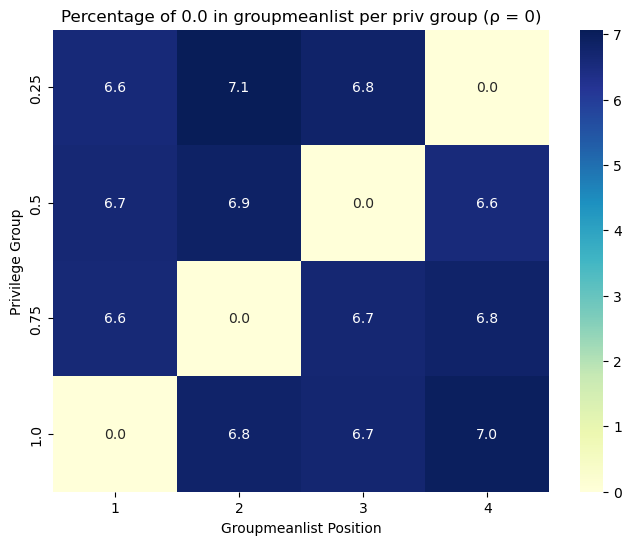

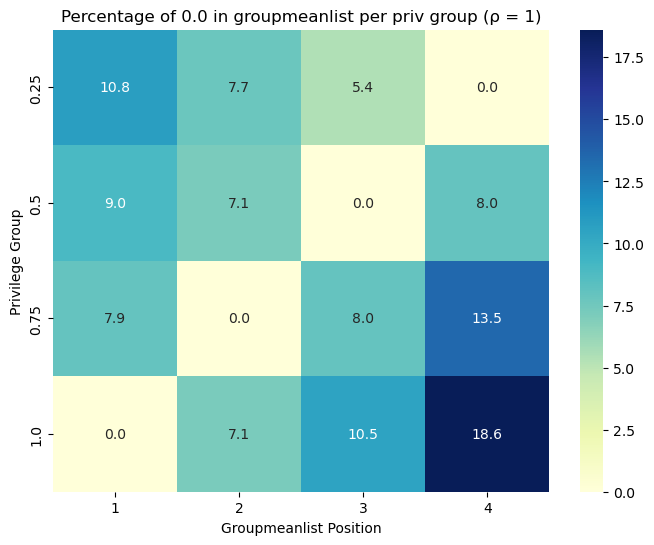

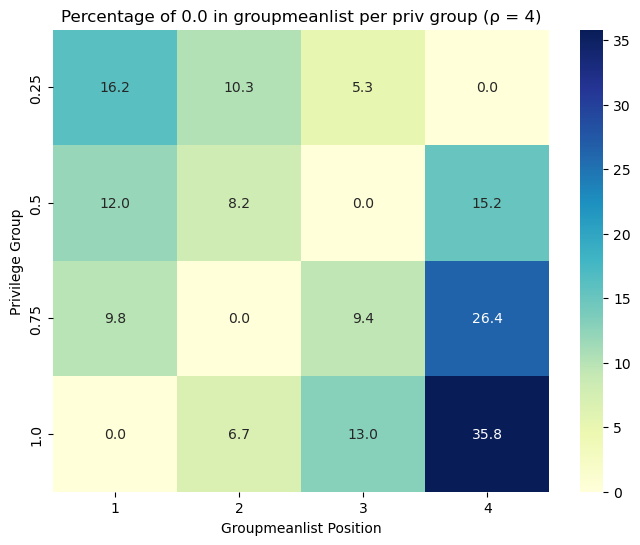

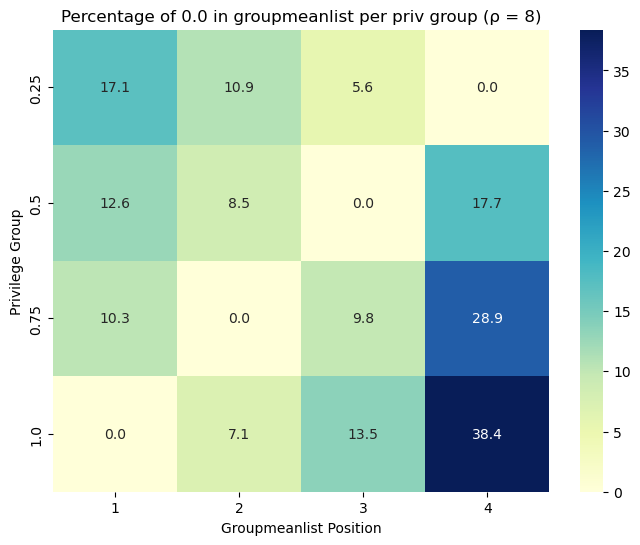

In [5]:
rho_values_to_plot = [0, 1, 4, 8]

for rho in rho_values_to_plot:
    # Filter original dataframe (assuming combined_df contains potentially 0.0 values)
    df_rho = combined_df[combined_df['rho_value'] == rho].copy()
    
    # Ensure groupmeanlist is not null
    df_rho = df_rho[~df_rho['groupmeanlist'].isnull()]
    
    # Create a column with list positions for the groupmeanlist (positions 1 to N)
    df_rho['position'] = df_rho['groupmeanlist'].apply(lambda x: list(range(1, len(x)+1)))
    
    # Explode both 'groupmeanlist' and 'position' so each element is on its own row
    df_exploded = df_rho.explode(['groupmeanlist', 'position'])
    
    # Count total entries per priv group and list position
    total_table = df_exploded.groupby(['priv','position']).size().unstack(fill_value=0)
    
    # Count entries where groupmeanlist is 0.0 per priv group and list position
    zeros_table = df_exploded[df_exploded['groupmeanlist'] == 0.0].groupby(['priv','position']).size().unstack(fill_value=0)
    
    # Calculate the percentage of 0.0s per group: (zeros / total) * 100
    percentage_table = (zeros_table / total_table * 100).fillna(0)
    
    # Plot the heatmap of percentages
    plt.figure(figsize=(8, 6))
    sns.heatmap(percentage_table, annot=True, fmt=".1f", cmap="YlGnBu")
    plt.title(f'Percentage of 0.0 in groupmeanlist per priv group (ρ = {rho})')
    plt.xlabel('Groupmeanlist Position')
    plt.ylabel('Privilege Group')
    plt.show()

### Differences in own income and group income (grouped by priv) - Box/Violin Plot

In [6]:
rho_subset = combined_df[combined_df['rho_value'].isin([0, 1, 4, 8])].copy()
rho_subset_clean = combined_df_clean[combined_df_clean['rho_value'].isin([0, 1, 4, 8])].copy()

In [7]:
# compare values from groupmeanlist of each individual to own income (group by priv group)
for idx in range(4):
    rho_subset.loc[:, f'difference_{idx+1}'] = rho_subset.apply(lambda i: i['Y'] - i['groupmeanlist'][idx], axis=1)
    rho_subset_clean.loc[:, f'difference_{idx+1}'] = rho_subset_clean.apply(lambda i: i['Y'] - i['groupmeanlist'][idx], axis=1)

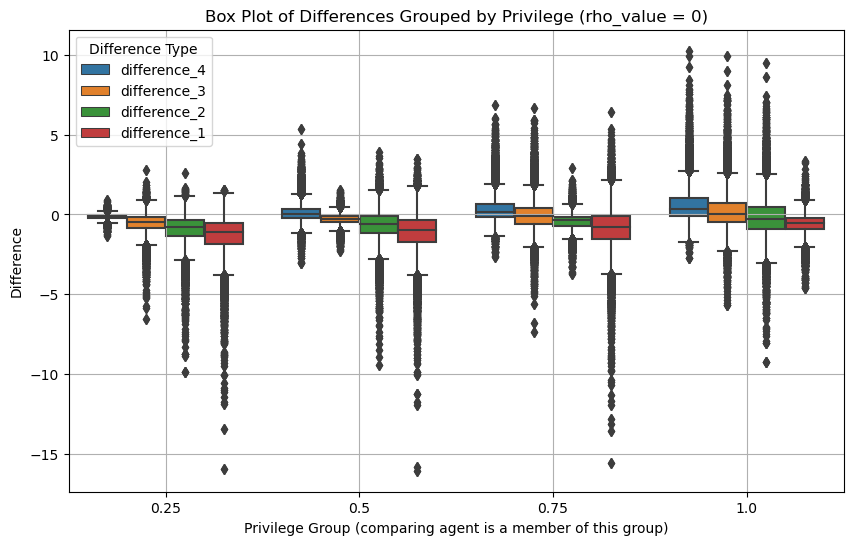

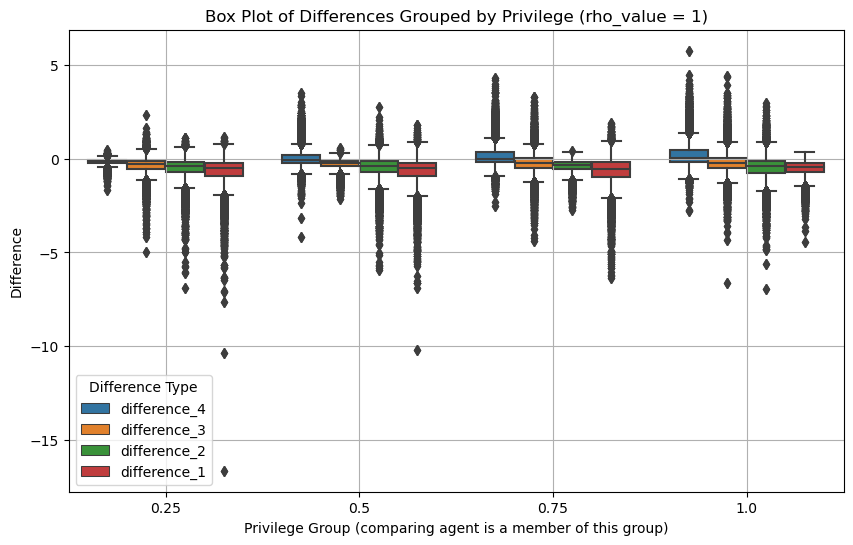

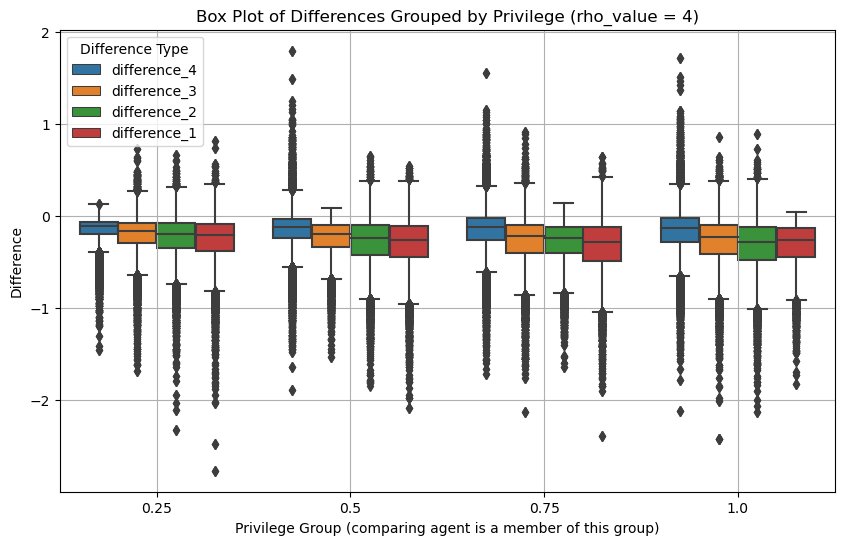

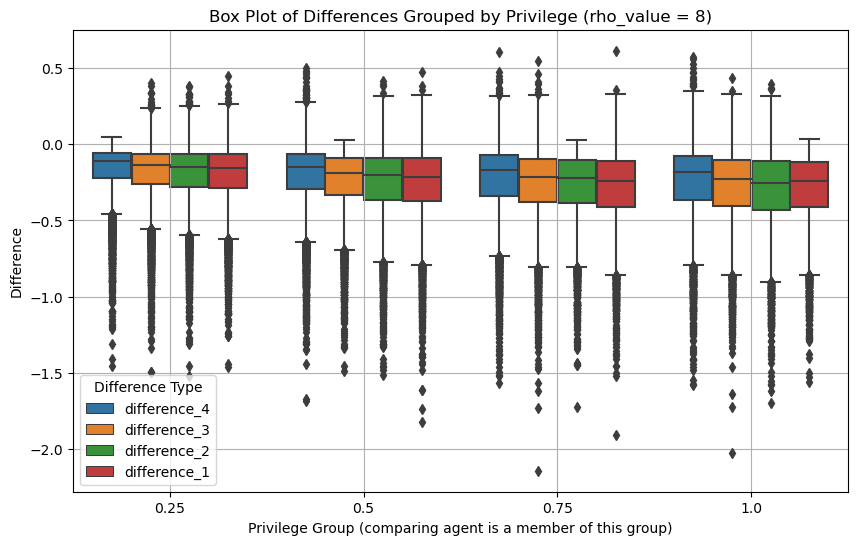

In [8]:
# Melt the dataframe to combine all difference columns into a single column for plotting
rho_melted = rho_subset_clean.melt(id_vars=['priv', 'rho_value'], 
                          value_vars=['difference_4', 'difference_3', 'difference_2', 'difference_1'], 
                          var_name='Difference Type', 
                          value_name='Difference')

# Create separate box plots for each rho_value
for rho in [0, 1, 4, 8]:
    plt.figure(figsize=(10, 6))
    subset = rho_melted[rho_melted['rho_value'] == rho]
    sns.boxplot(data=subset, x='priv', y='Difference', hue='Difference Type')
    plt.title(f'Box Plot of Differences Grouped by Privilege (rho_value = {rho})')
    plt.xlabel('Privilege Group (comparing agent is a member of this group)')
    plt.ylabel('Difference')
    plt.legend(title='Difference Type')
    plt.grid(True)
    plt.show()

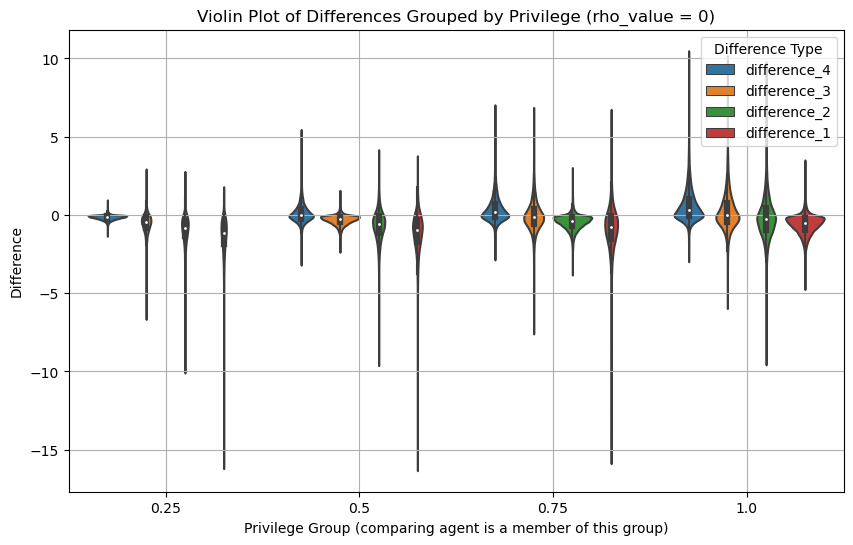

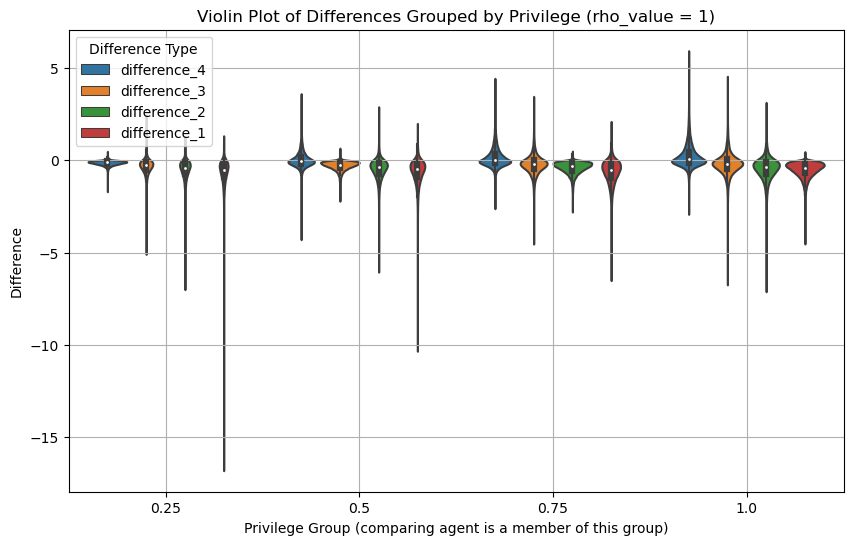

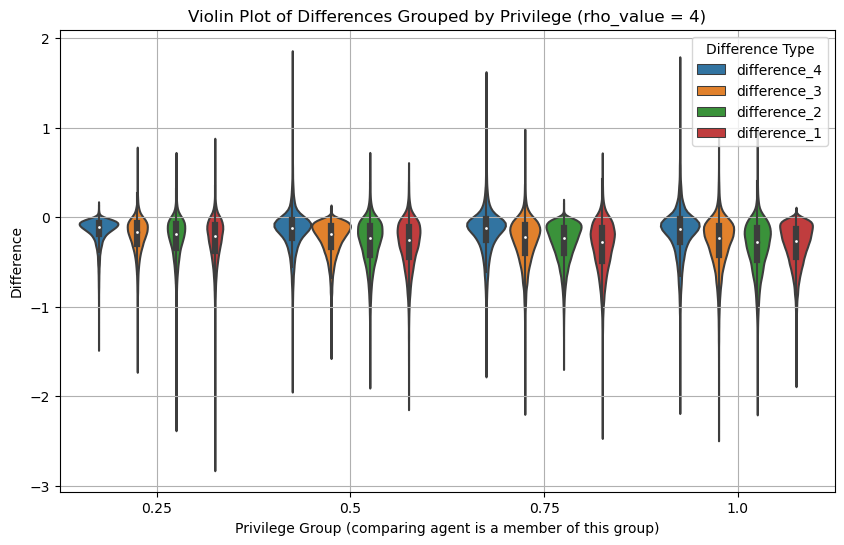

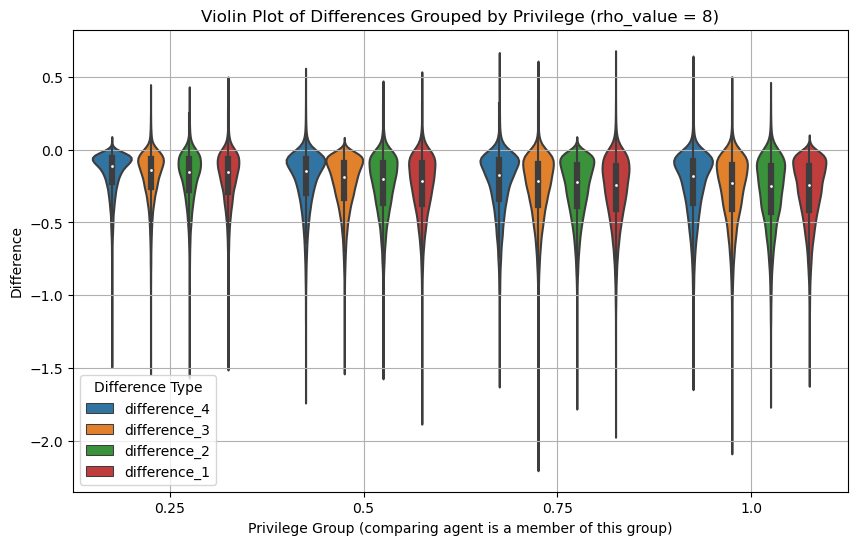

In [9]:
# Create separate box plots for each rho_value
for rho in [0, 1, 4, 8]:
    plt.figure(figsize=(10, 6))
    subset = rho_melted[rho_melted['rho_value'] == rho]
    sns.violinplot(data=subset, x='priv', y='Difference', hue='Difference Type')
    plt.title(f'Violin Plot of Differences Grouped by Privilege (rho_value = {rho})')
    plt.xlabel('Privilege Group (comparing agent is a member of this group)')
    plt.ylabel('Difference')
    plt.legend(title='Difference Type')
    plt.grid(True)
    plt.show()

### - Scatterplot

In [10]:
count = combined_df[(combined_df['run'] == 1) & (combined_df['rho_value'] == 0)].shape[0]
print(f"Number of rows where run is 1 and rho_value is 4: {count}")

Number of rows where run is 1 and rho_value is 4: 2000


In [11]:
# Define a color mapping for positions (optional)
position_colors = {1: '#440154FF', 2: '#414487FF', 3: '#7AD151FF', 4: '#FDE725FF'}

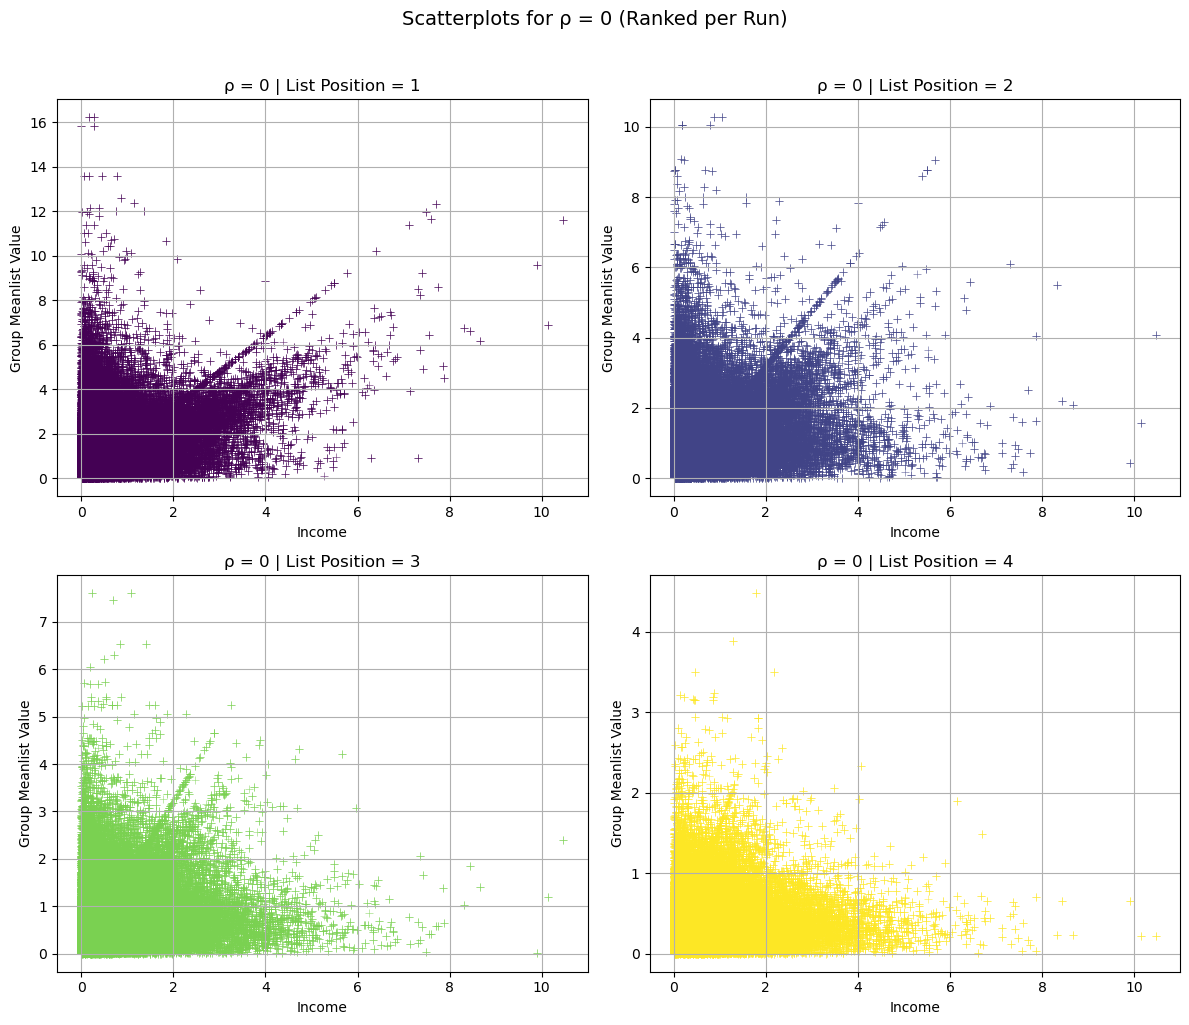

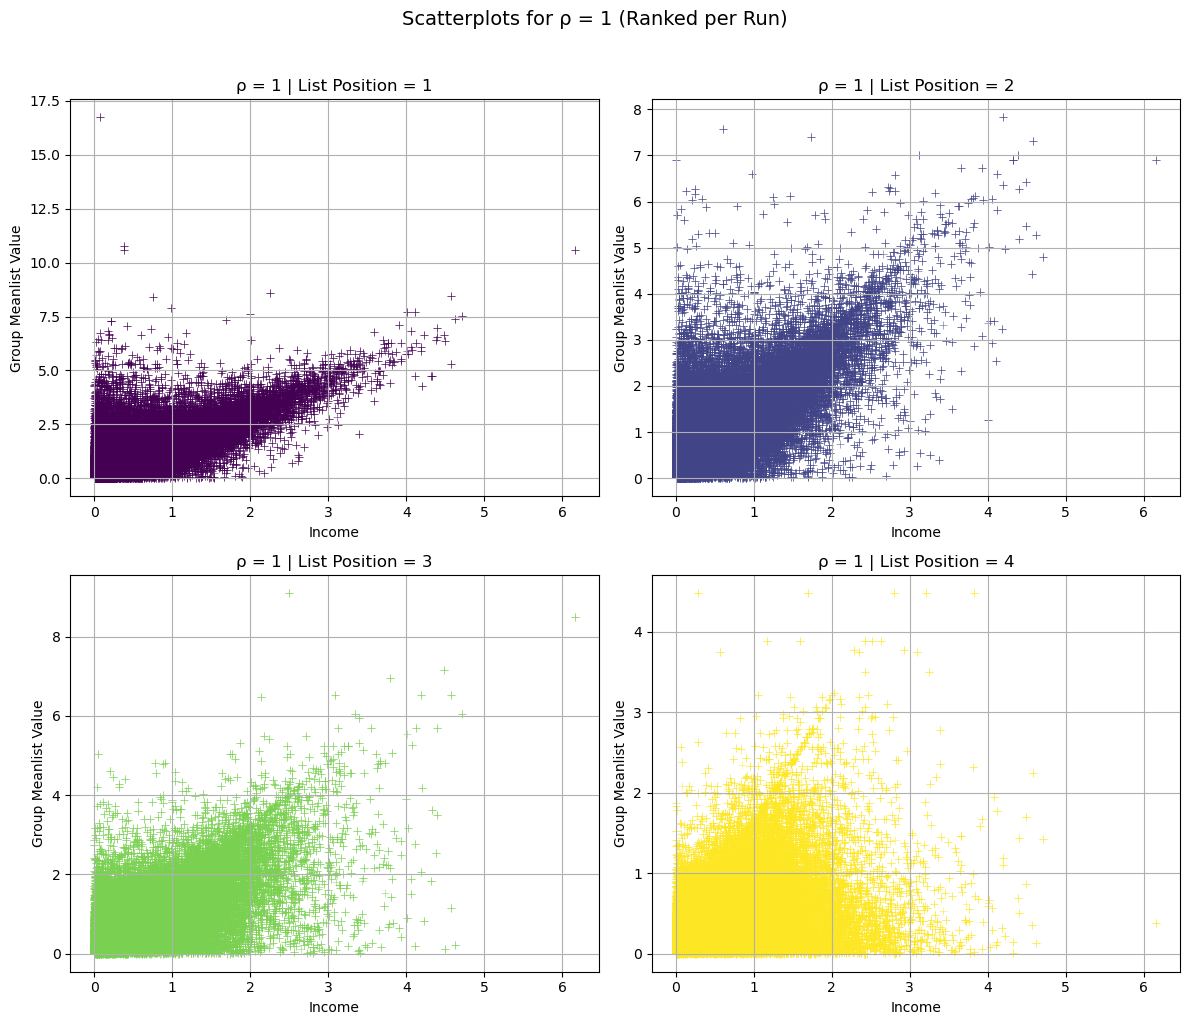

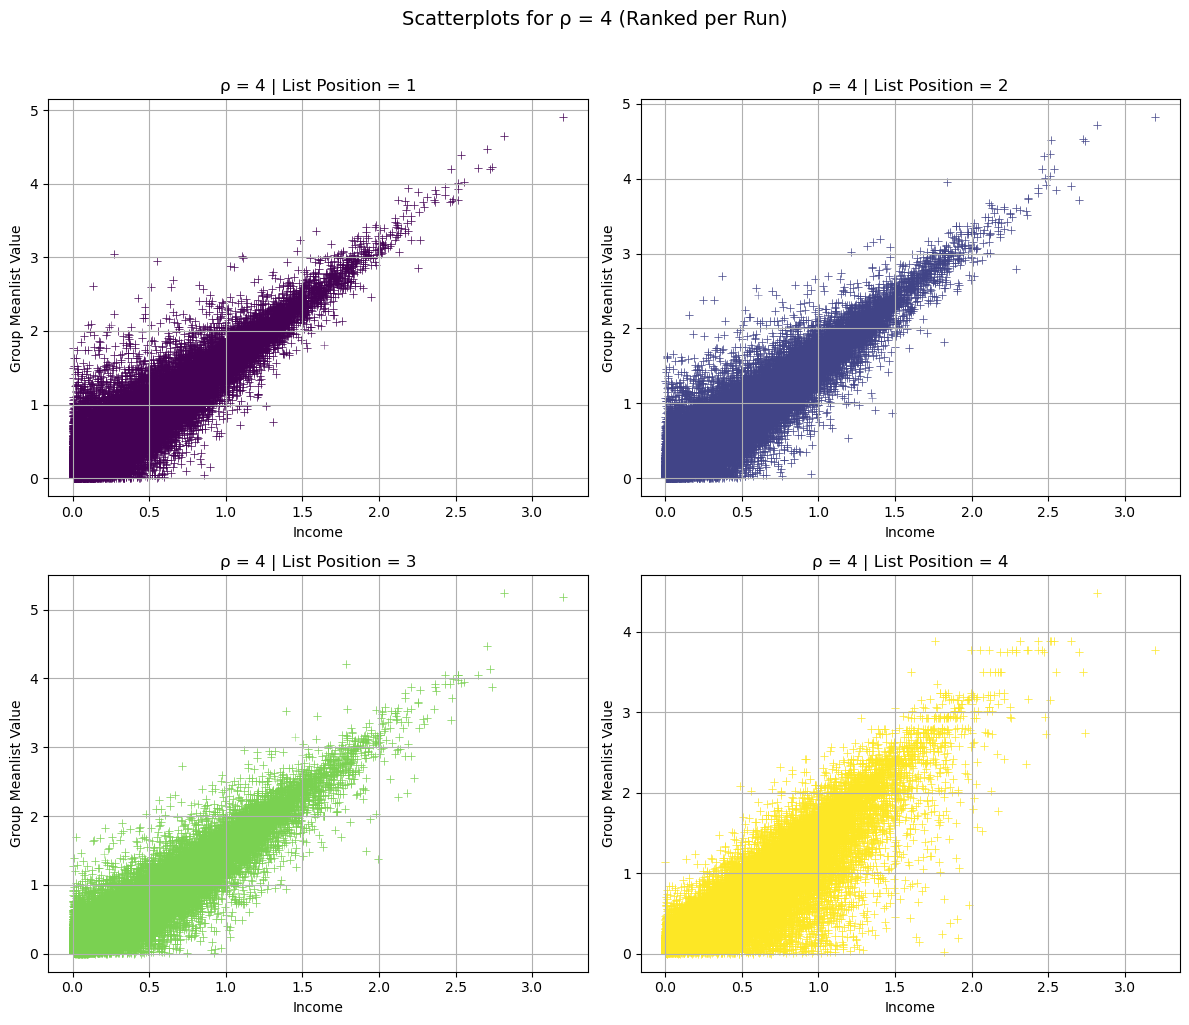

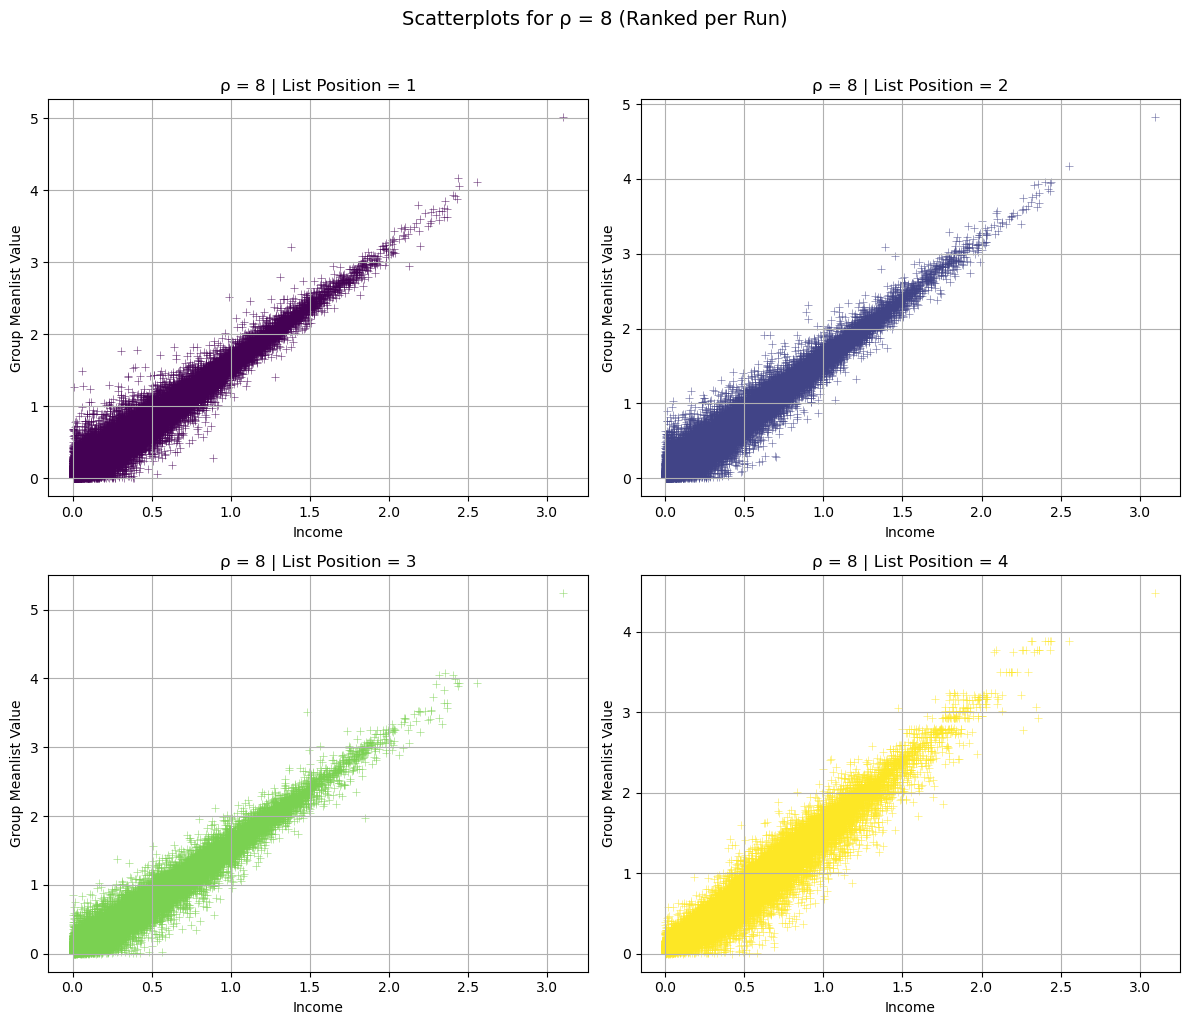

In [47]:
for rho in rho_values_to_plot:
    # Filter for current rho and ensure groupmeanlist is not null
    df_rho = combined_df_clean[combined_df_clean['rho_value'] == rho].copy()
    df_rho = df_rho[~df_rho['groupmeanlist'].isnull()]
    
    # Compute income rank per run (each run ranked from 1 to 2000)
    df_rho['income_rank'] = df_rho.groupby('run')['Y'].rank(method='first', ascending=False).astype(int)
    
    # Create a column with list positions (1-indexed)
    df_rho['position'] = df_rho['groupmeanlist'].apply(lambda x: list(range(1, len(x)+1)))
    
    # Explode so that each element in groupmeanlist and its position becomes its own row
    df_exploded = df_rho.explode(['groupmeanlist', 'position'])
    
    # Create a 2x2 grid of subplots (one per list position)
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    # Loop through each list position and plot the datapoints (binned by income rank per run)
    for pos in sorted(df_exploded['position'].unique()):
        ax = axes[pos - 1]  # positions are 1-indexed
        subset = df_exploded[df_exploded['position'] == pos]
        sns.scatterplot(
            data=subset,
            x='Y',
            y='groupmeanlist',
            color=position_colors.get(pos, 'blue'),
            marker="+",
            alpha=0.7,
            ax=ax
        )
        ax.set_title(f'ρ = {rho} | List Position = {pos}')
        ax.set_xlabel('Income')
        ax.set_ylabel('Group Meanlist Value')
        ax.grid(True)
    
    fig.suptitle(f'Scatterplots for ρ = {rho} (Ranked per Run)', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

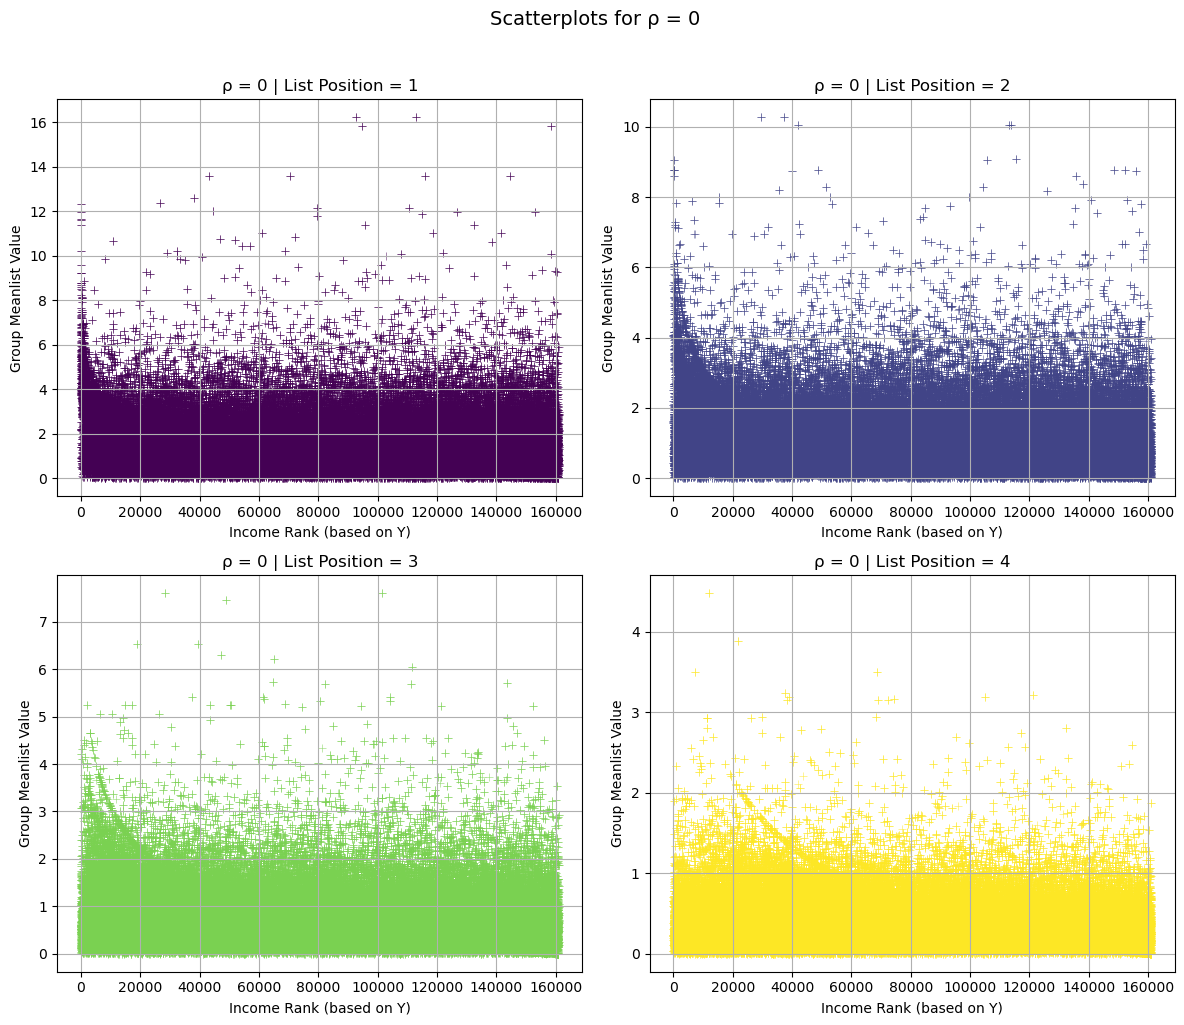

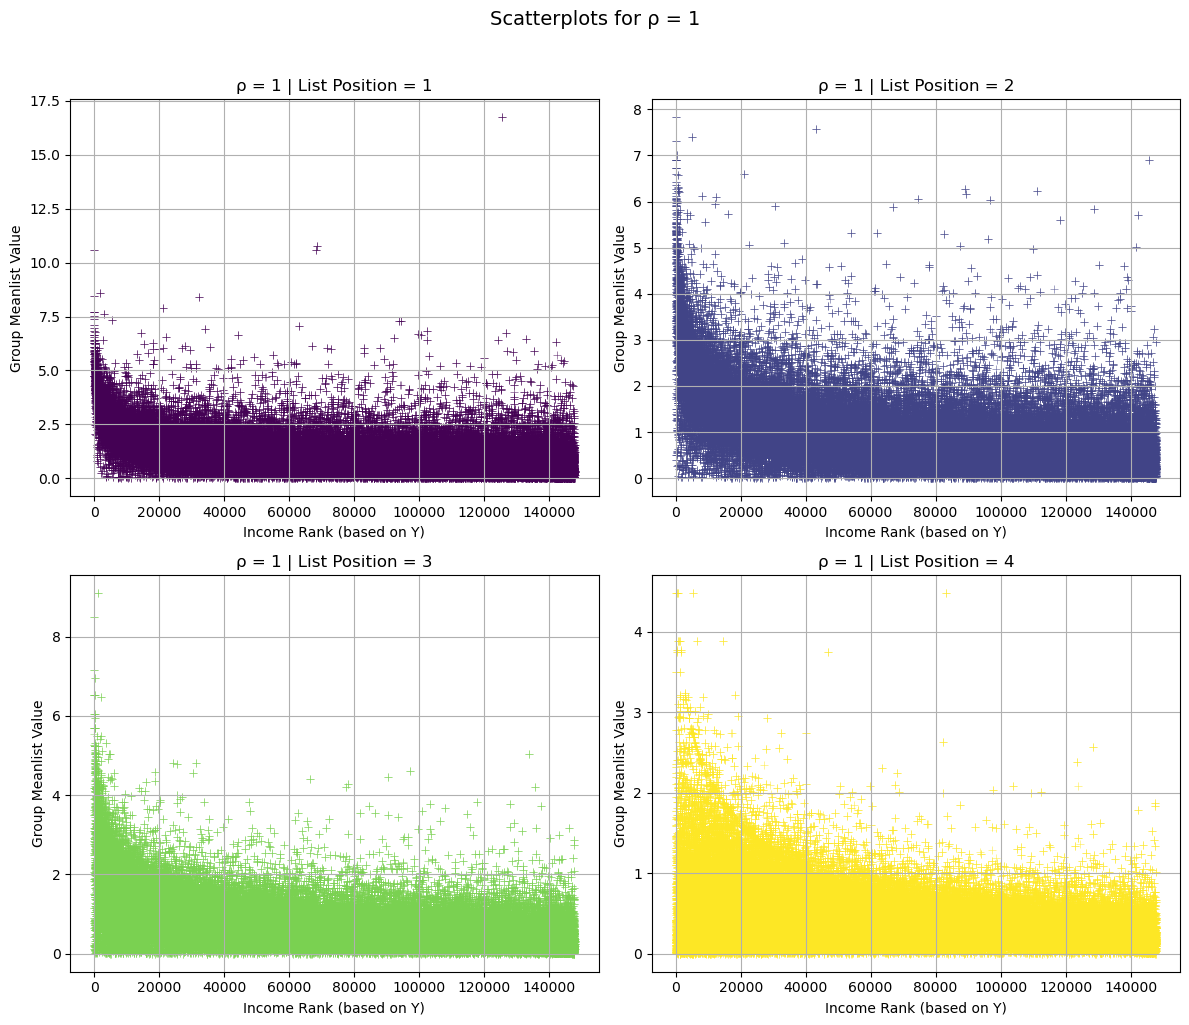

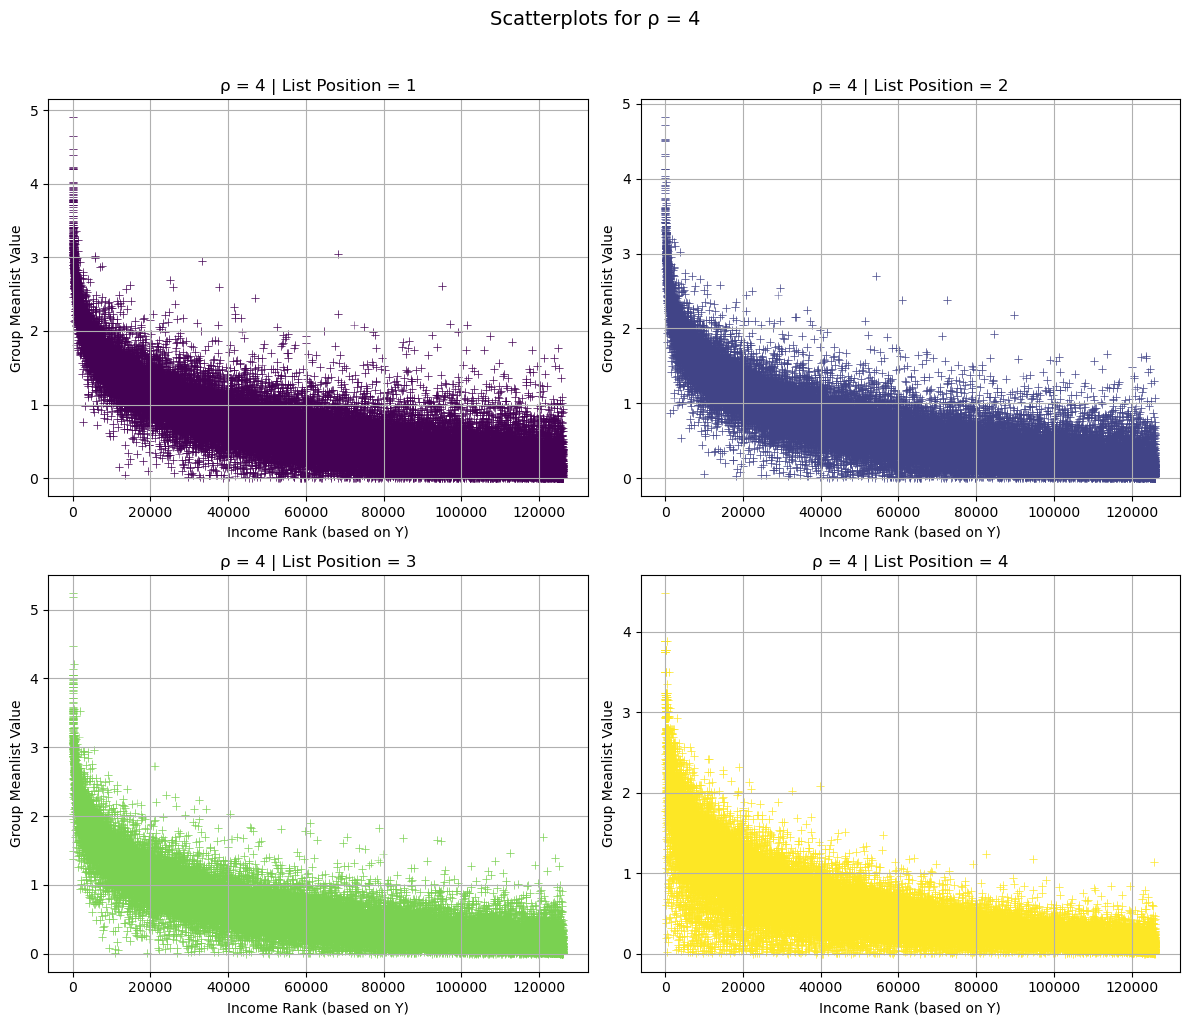

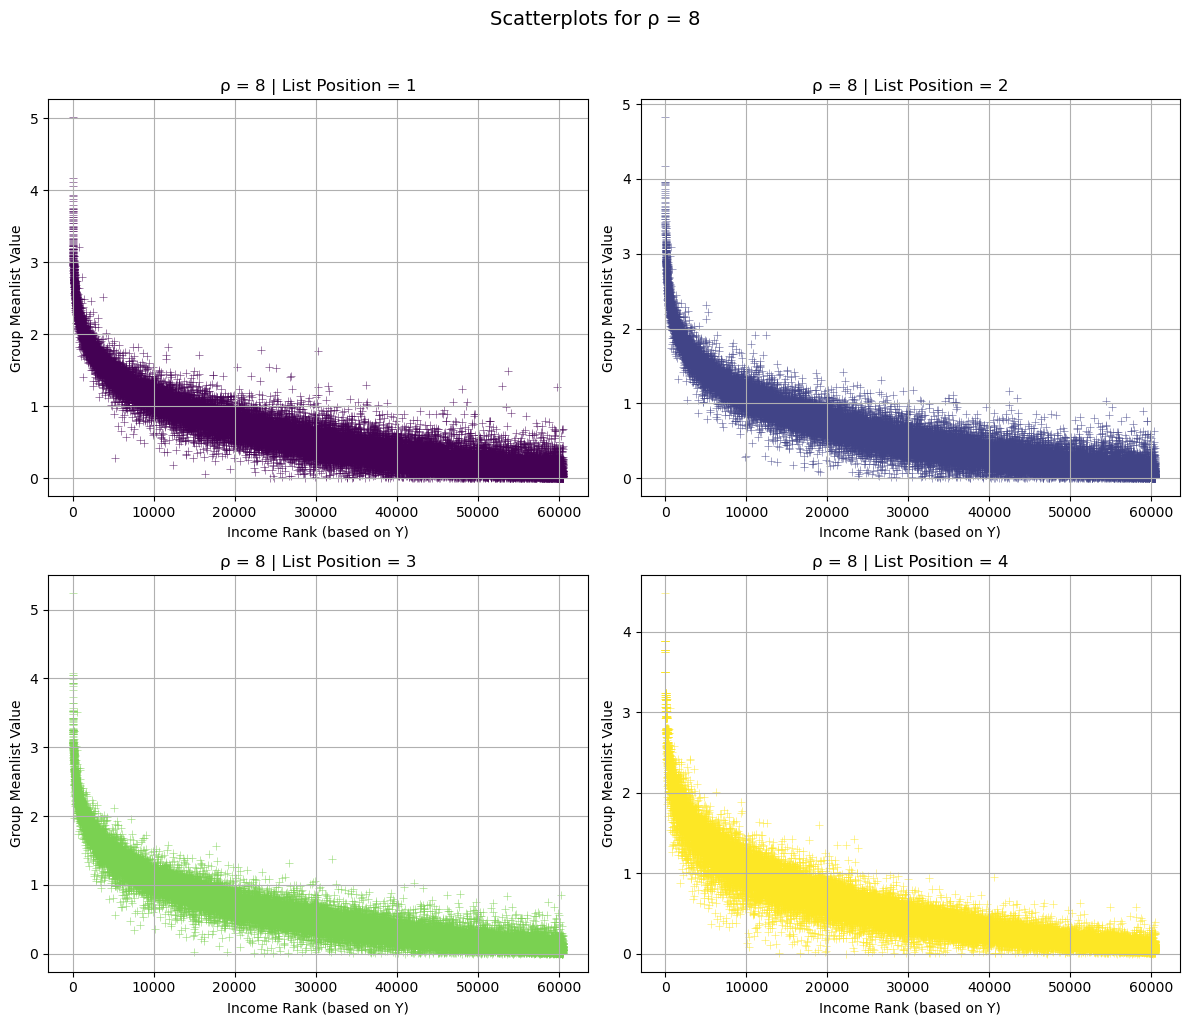

In [ ]:
for rho in rho_values_to_plot:
    # Filter data for a given rho and ensure groupmeanlist is not null
    df_rho = combined_df_clean[combined_df_clean['rho_value'] == rho].copy()
    df_rho = df_rho[~df_rho['groupmeanlist'].isnull()]
    
    # Compute income rank (descending order)
    df_rho['income_rank'] = df_rho['Y'].rank(method='first', ascending=False).astype(int)
    
    # Create a column with list positions (1-indexed)
    df_rho['position'] = df_rho['groupmeanlist'].apply(lambda x: list(range(1, len(x)+1)))
    
    # Explode so that each element in groupmeanlist and its position become separate rows
    df_exploded = df_rho.explode(['groupmeanlist', 'position'])
    
    # Create a 2x2 grid of subplots (for 4 list positions)
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    # Loop through each list position
    for pos in sorted(df_exploded['position'].unique()):
        ax = axes[pos - 1]  # positions are 1-indexed
        subset = df_exploded[df_exploded['position'] == pos]
        
        # Plot scatterplot for this list position (using a fixed color)
        sns.scatterplot(
            data=subset,
            x='income_rank',
            y='groupmeanlist',
            color=position_colors.get(pos, 'blue'),
            alpha=0.7,
            marker="+",
            ax=ax
        )
        ax.set_title(f'ρ = {rho} | List Position = {pos}')
        ax.set_xlabel('Income Rank (based on Y)')
        ax.set_ylabel('Group Meanlist Value')
        ax.grid(True)
    
    fig.suptitle(f'Scatterplots for ρ = {rho}', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

the horizontal line across at 0 means they have no groupmeanlist values for second third fourth group (what to do with these individuals? drop or keep?). as expected, higher rho value = more linear relationship (their Y matches that of the average of the groups they belong to).

follow up -> have it for rho 0 and 4 but inspect by their income vs the group mean for each group mean.

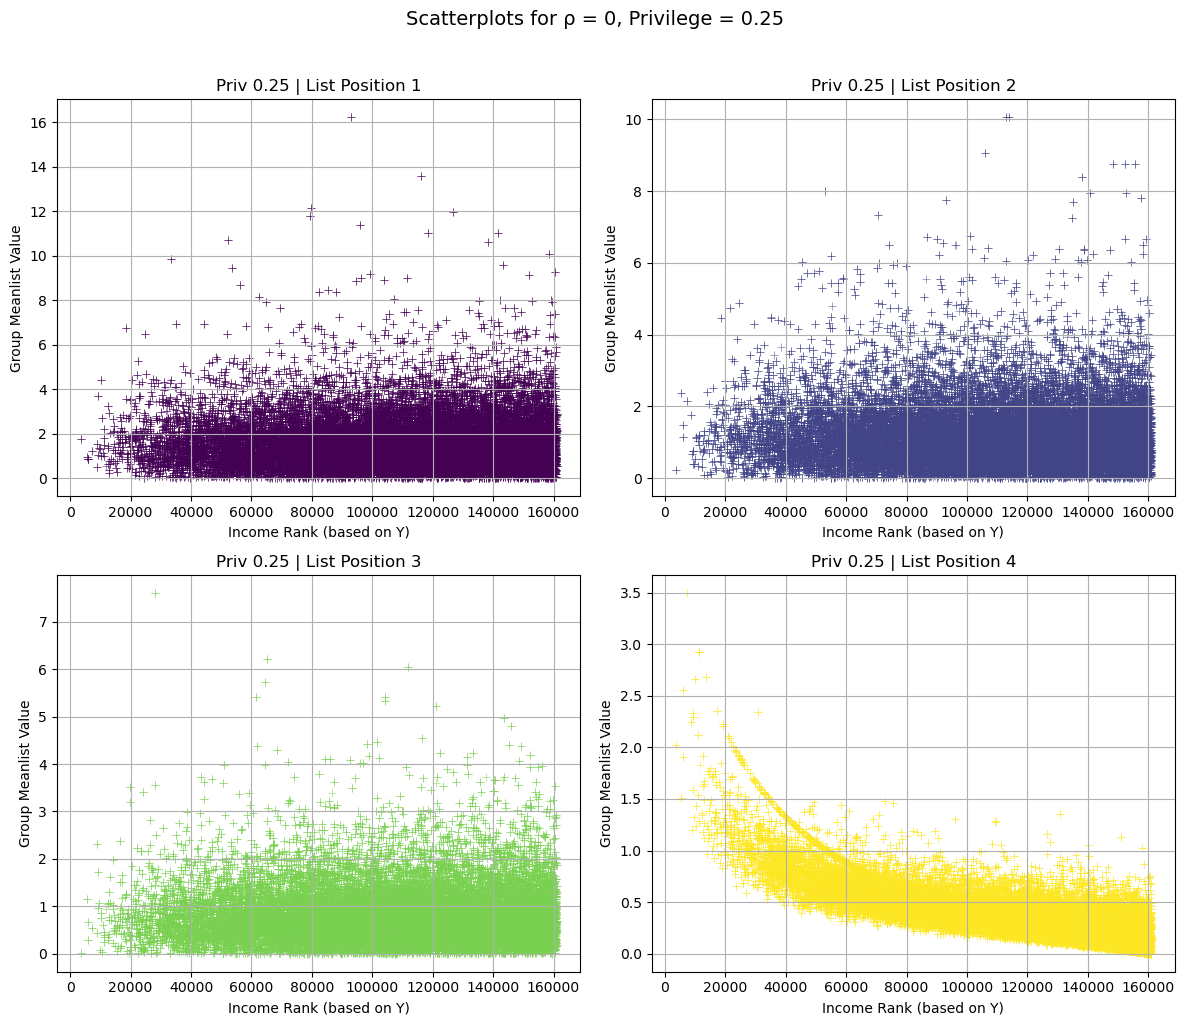

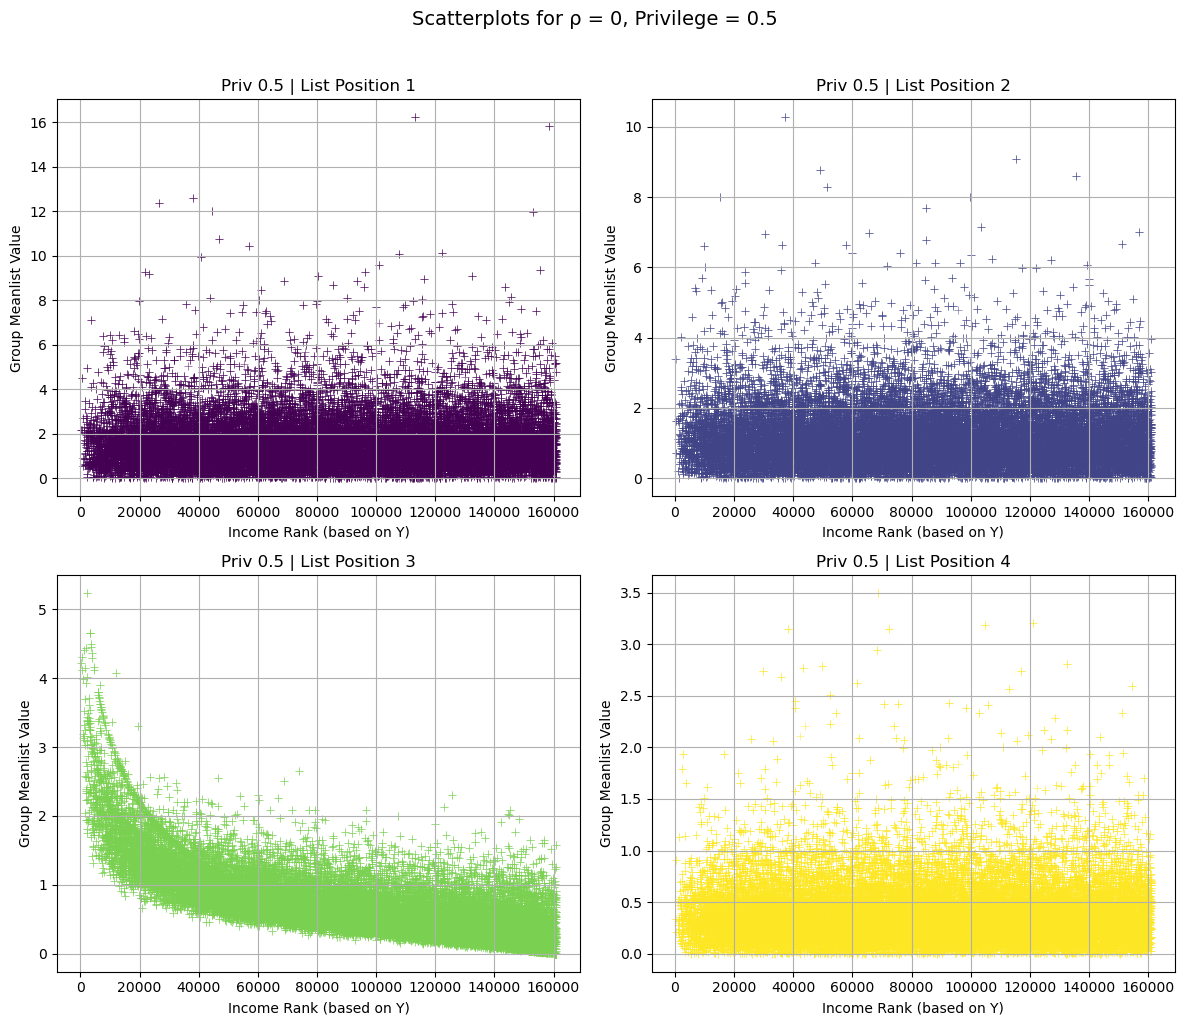

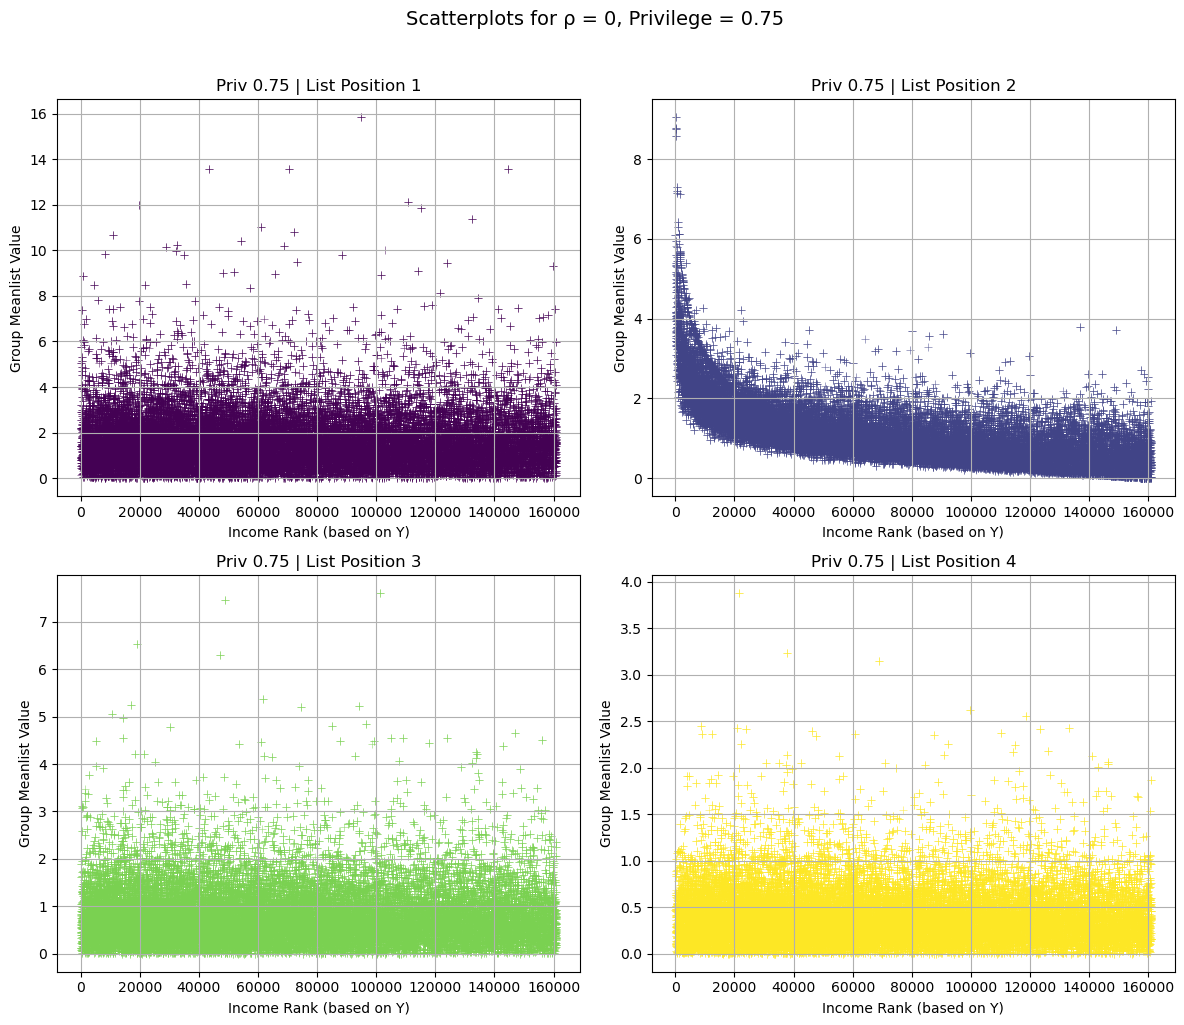

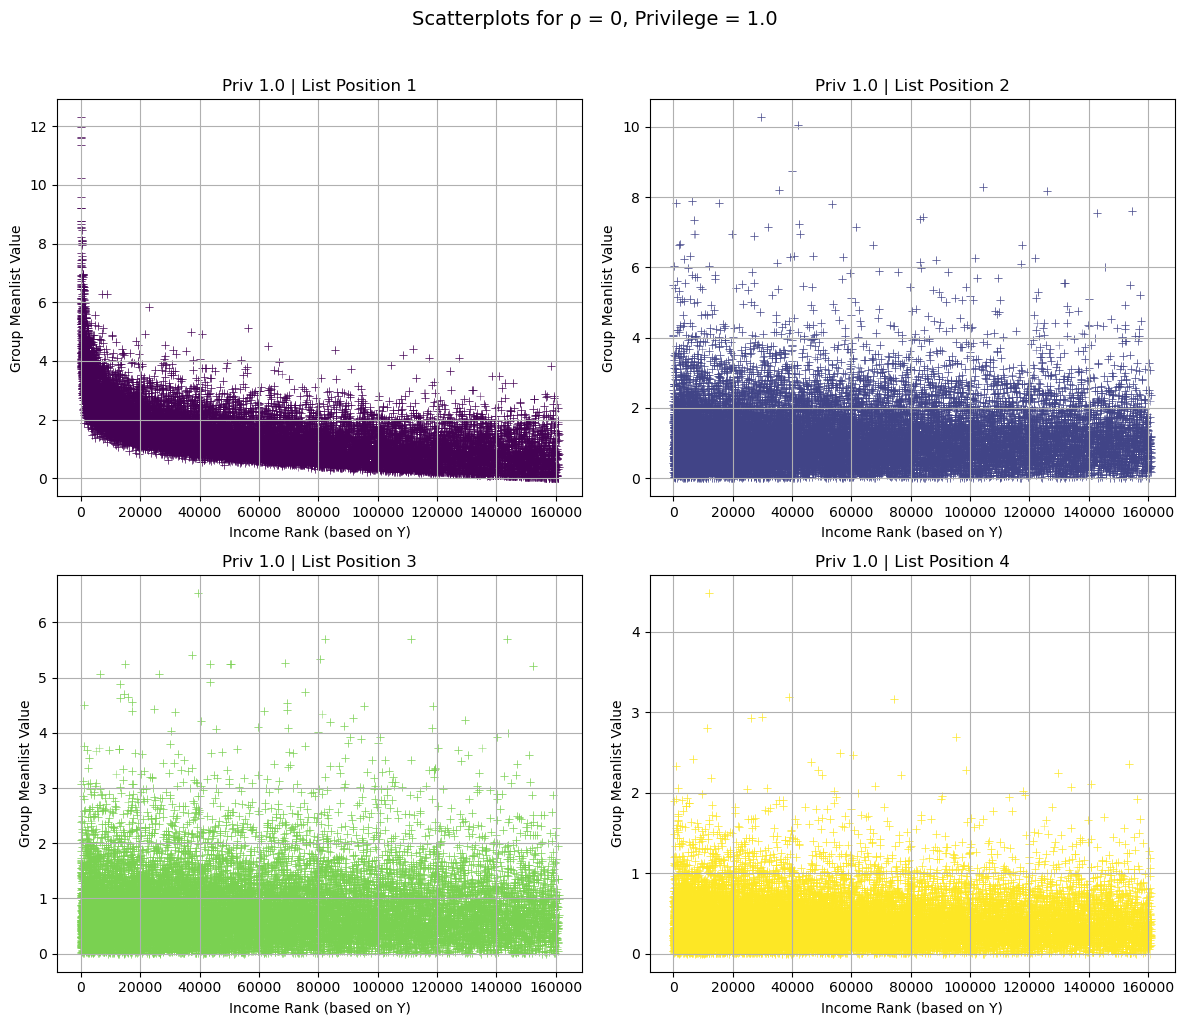

In [15]:
# Scatterplots for ρ = 0 stratified by privilege group: one 2x2 grid per priv group

# Filter data for ρ = 0 and ensure groupmeanlist is not null
df_rho0 = combined_df_clean[combined_df_clean['rho_value'] == 0].copy()
df_rho0 = df_rho0[~df_rho0['groupmeanlist'].isnull()]

# Compute income rank (descending order based on Y)
df_rho0['income_rank'] = df_rho0['Y'].rank(method='first', ascending=False).astype(int)

# Create a column with list positions (1-indexed)
df_rho0['position'] = df_rho0['groupmeanlist'].apply(lambda x: list(range(1, len(x)+1)))

# Explode so that each element in groupmeanlist along with its position becomes its own row
df0_exploded = df_rho0.explode(['groupmeanlist', 'position'])

# For each privilege group, create a 2x2 grid (one subplot per list position)
for priv_group in sorted(df0_exploded['priv'].unique()):
    subset_priv = df0_exploded[df0_exploded['priv'] == priv_group]
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    for pos in sorted(subset_priv['position'].unique()):
        ax = axes[pos - 1]
        pos_subset = subset_priv[subset_priv['position'] == pos]
        
        sns.scatterplot(
            data=pos_subset,
            x='income_rank',
            y='groupmeanlist',
            color=position_colors.get(pos, 'blue'),
            alpha=0.7,
            marker="+",
            ax=ax
        )
        ax.set_title(f'Priv {priv_group} | List Position {pos}')
        ax.set_xlabel('Income Rank (based on Y)')
        ax.set_ylabel('Group Meanlist Value')
        ax.grid(True)
    
    fig.suptitle(f'Scatterplots for ρ = 0, Privilege = {priv_group}', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

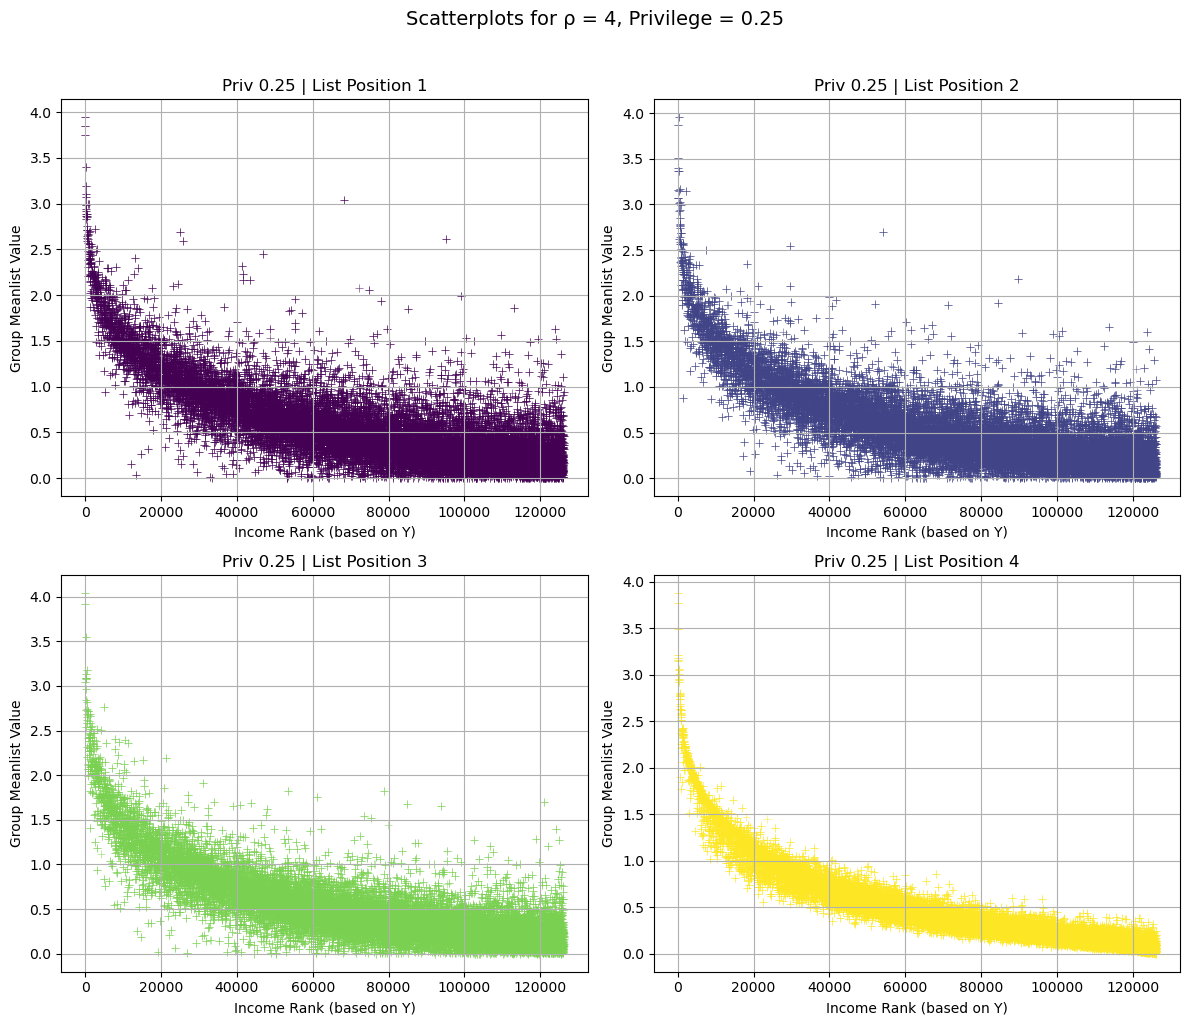

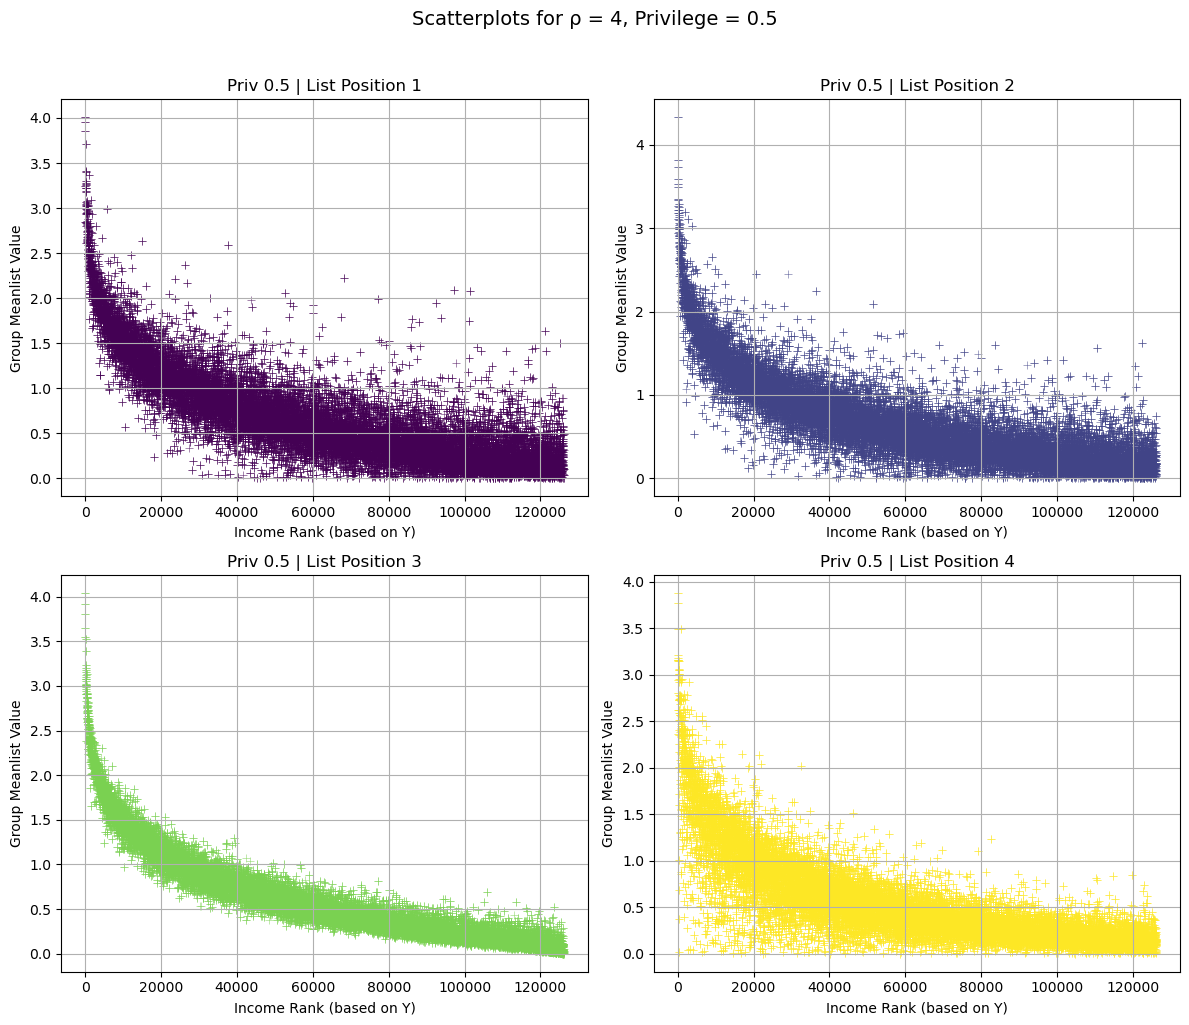

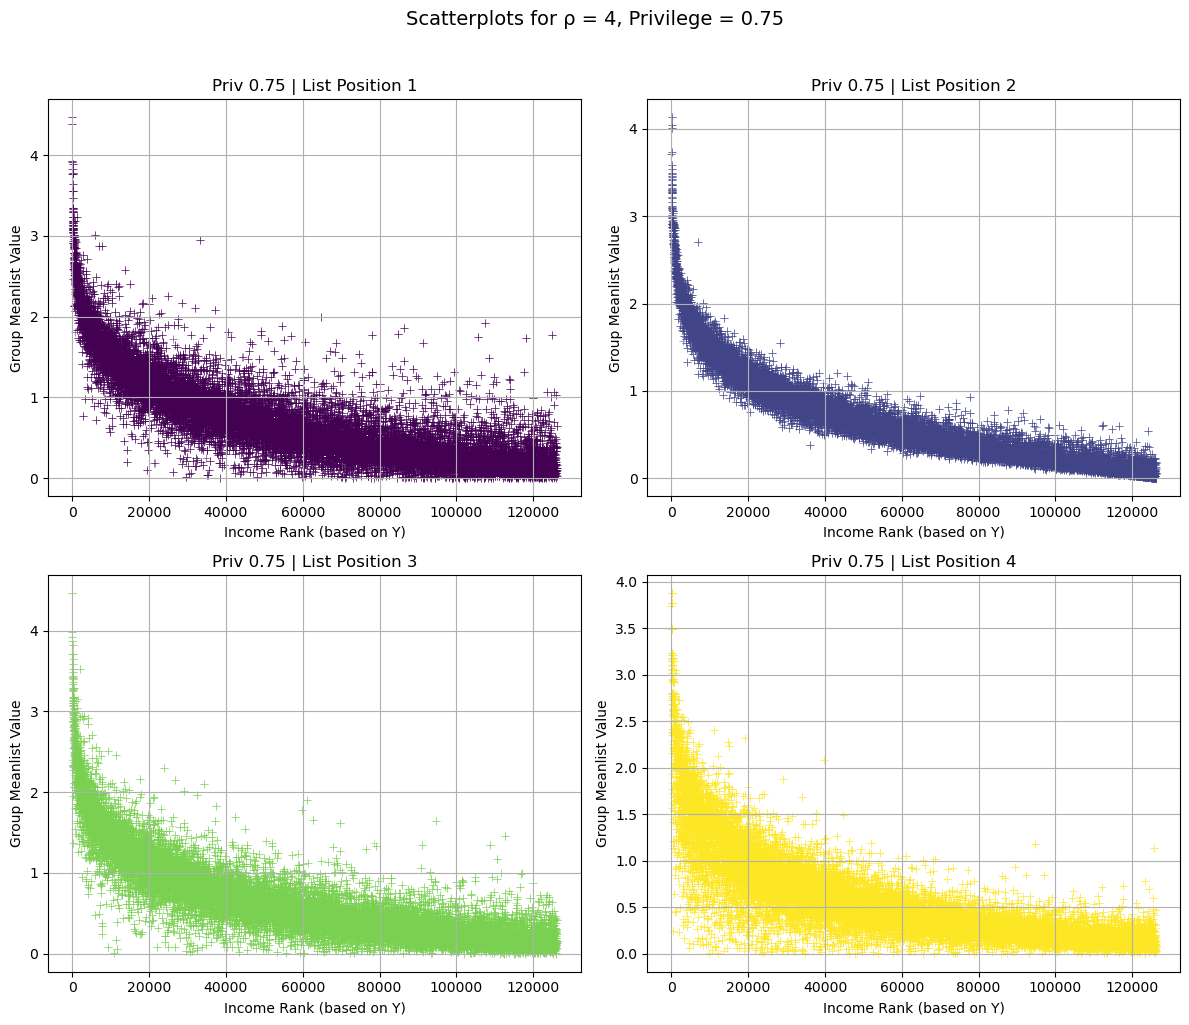

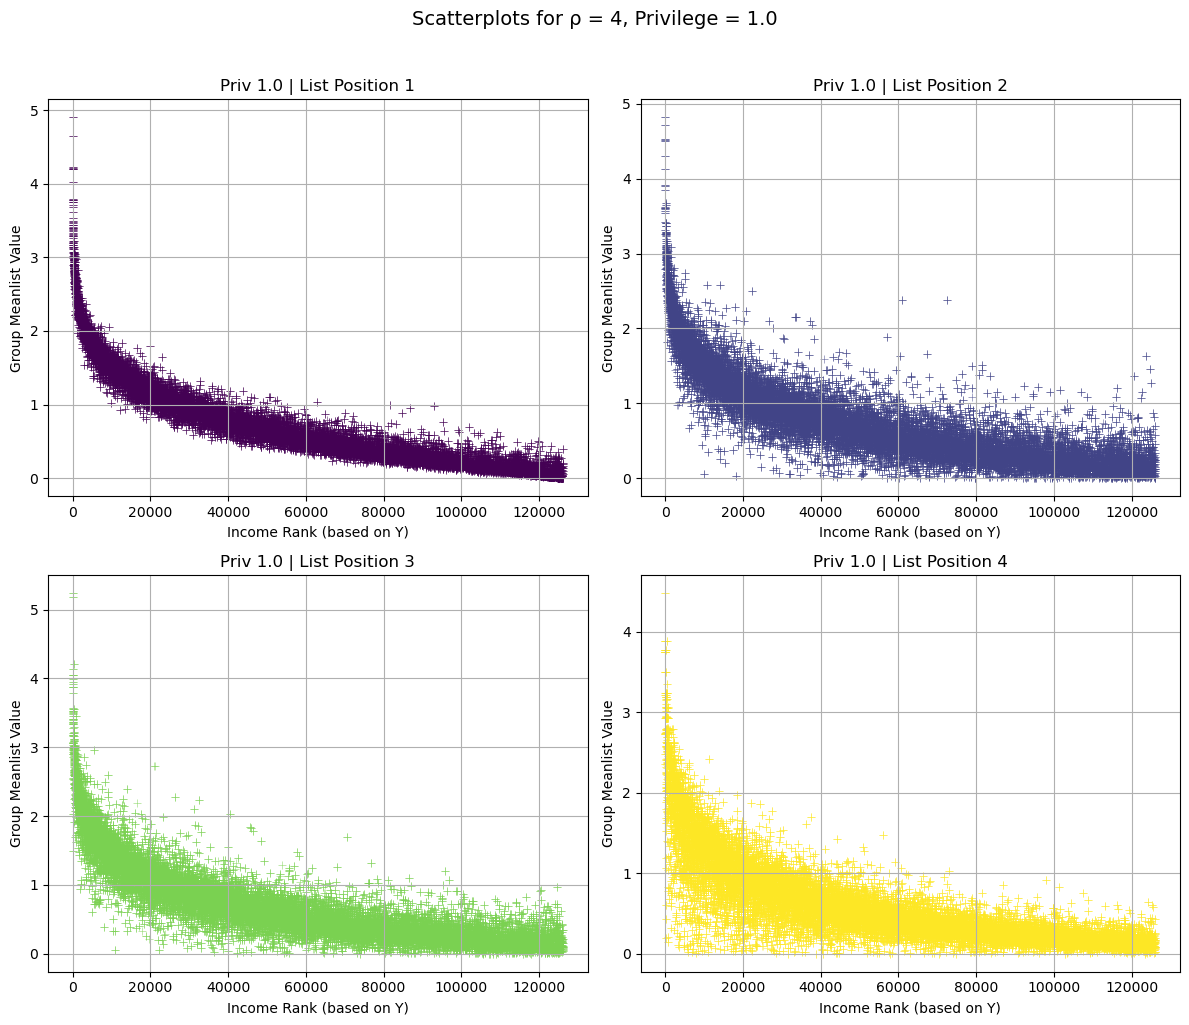

In [16]:
# Scatterplots for ρ = 4 stratified by privilege group: one 2x2 grid per priv group

# Filter data for ρ = 4 and ensure groupmeanlist is not null
rho_4 = combined_df_clean[combined_df_clean['rho_value'] == 4].copy()
rho_4 = rho_4[~rho_4['groupmeanlist'].isnull()]

# Compute income rank (descending order based on Y)
rho_4['income_rank'] = rho_4['Y'].rank(method='first', ascending=False).astype(int)

# Create a column with list positions (1-indexed)
rho_4['position'] = rho_4['groupmeanlist'].apply(lambda x: list(range(1, len(x)+1)))

# Explode so that each element in groupmeanlist along with its position becomes its own row
df4_exploded = rho_4.explode(['groupmeanlist', 'position'])

# For each privilege group, create a 2x2 grid of subplots (one for each list position)
for priv_group in sorted(df4_exploded['priv'].unique()):
    subset_priv = df4_exploded[df4_exploded['priv'] == priv_group]
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    for pos in sorted(subset_priv['position'].unique()):
        ax = axes[pos - 1]
        pos_subset = subset_priv[subset_priv['position'] == pos]
        
        sns.scatterplot(
            data=pos_subset,
            x='income_rank',
            y='groupmeanlist',
            color=position_colors.get(pos, 'blue'),
            alpha=0.7,
            marker="+",
            ax=ax
        )
        ax.set_title(f'Priv {priv_group} | List Position {pos}')
        ax.set_xlabel('Income Rank (based on Y)')
        ax.set_ylabel('Group Meanlist Value')
        ax.grid(True)
    
    fig.suptitle(f'Scatterplots for ρ = 4, Privilege = {priv_group}', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

### - Heatmap

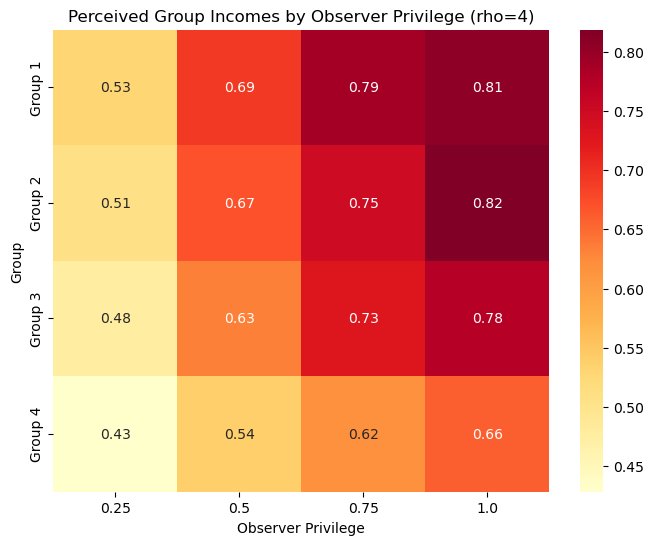

In [17]:
# For rho=4, build the pivot table with mean value per group (assuming four elements per groupmeanlist)
heatmap_data = pd.DataFrame({
    'Group 1': rho_4.groupby('priv')['groupmeanlist'].apply(lambda x: np.mean([lst[0] for lst in x])),
    'Group 2': rho_4.groupby('priv')['groupmeanlist'].apply(lambda x: np.mean([lst[1] for lst in x])),
    'Group 3': rho_4.groupby('priv')['groupmeanlist'].apply(lambda x: np.mean([lst[2] for lst in x])),
    'Group 4': rho_4.groupby('priv')['groupmeanlist'].apply(lambda x: np.mean([lst[3] for lst in x]))
}).T

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap="YlOrRd")
plt.title("Perceived Group Incomes by Observer Privilege (rho=4)")
plt.xlabel("Observer Privilege")
plt.ylabel("Group")
plt.show()

How different privilege groups perceive the income levels of the groups they interact with.
 shows how sharply agents of a given privilege group perceive income differences across social categories.

Comparing perceptions to true group means:

In [34]:
rho_4_uncleaned = combined_df[combined_df['rho_value'] == 4].copy()
true_means = rho_4_uncleaned.groupby('priv')['Y'].mean().to_dict()  
true_means

{0.25: 0.250030486210481,
 0.5: 0.49985512845771024,
 0.75: 0.749814715932165,
 1.0: 1.0003003394737298}

In [35]:
# Define group order (ensure alignment with groupmeanlist indices)
group_order = [1.0, 0.75, 0.5, 0.25]  # Highest to lowest privilege

# Calculate deviations for each groupmeanlist element
for i in range(4):
    rho_4[f'deviation_group_{i+1}'] = rho_4['groupmeanlist'].apply(
        lambda lst: (lst[i] - true_means[group_order[i]]) / true_means[group_order[i]] * 100
    )

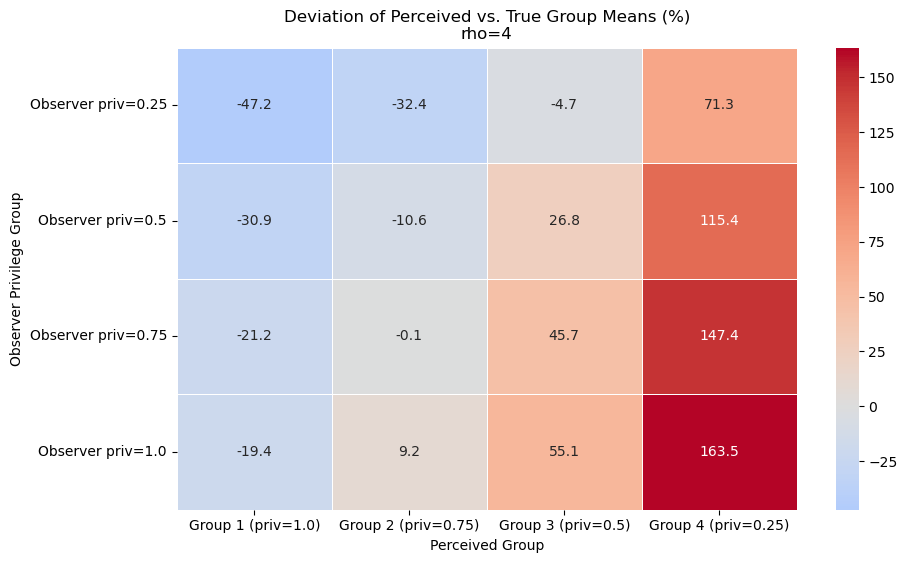

In [36]:
# Aggregate deviations by observer's privilege group
heatmap_data_true = rho_4.groupby('priv')[[f'deviation_group_{i+1}' for i in range(4)]].mean()

# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_data_true,
    annot=True,
    cmap="coolwarm",
    center=0,
    fmt=".1f",
    linewidths=0.5,
    xticklabels=[f"Group {i+1} (priv={group_order[i]})" for i in range(4)],
    yticklabels=[f"Observer priv={p}" for p in heatmap_data_true.index]
)
plt.title("Deviation of Perceived vs. True Group Means (%)\nrho=4")
plt.xlabel("Perceived Group")
plt.ylabel("Observer Privilege Group")
plt.show()

Comparing perceptions to average perceptions:

In [22]:
avg_perceptions = {
    f"group_{i+1}": rho_4['groupmeanlist'].apply(lambda lst: lst[i]).mean()
    for i in range(4)
}
avg_perceptions

{'group_1': 0.6940386450991791,
 'group_2': 0.6756708361679364,
 'group_3': 0.6430694156781753,
 'group_4': 0.5530675123886352}

In [23]:
for i in range(4):
    rho_4[f'consensus_deviation_{i+1}'] = rho_4['groupmeanlist'].apply(
        lambda lst: (lst[i] - avg_perceptions[f"group_{i+1}"]) / avg_perceptions[f"group_{i+1}"] * 100
    )

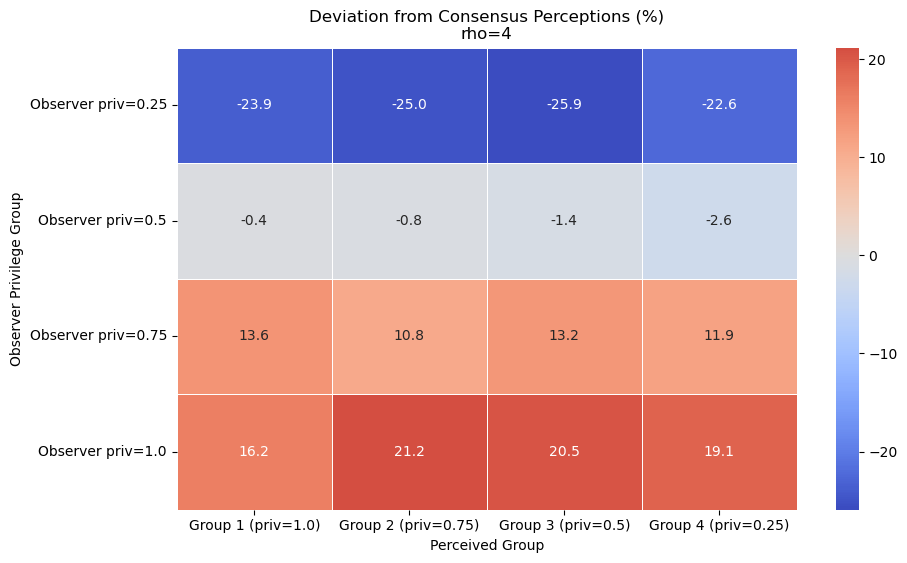

In [24]:
heatmap_data_consensus = rho_4.groupby('priv')[[f'consensus_deviation_{i+1}' for i in range(4)]].mean()

plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_data_consensus,
    annot=True,
    cmap="coolwarm",
    center=0,
    fmt=".1f",
    linewidths=0.5,
    xticklabels=[f"Group {i+1} (priv={group_order[i]})" for i in range(4)],
    yticklabels=[f"Observer priv={p}" for p in heatmap_data_consensus.index]
)
plt.title("Deviation from Consensus Perceptions (%)\nrho=4")
plt.xlabel("Perceived Group")
plt.ylabel("Observer Privilege Group")
plt.show()

Shows how groups diverge in perceptions. group 1 sees them self almsot 60% richer than the consensus (hard for others outside the group to be link neighbors with them so they grossly underestimate?)

### Perceived Priv Group vs Actual - Confusion Matrix

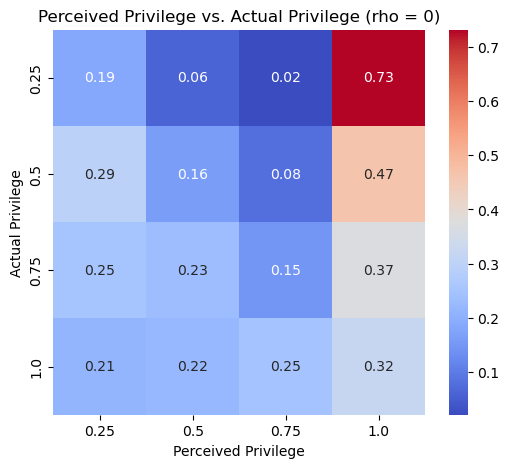

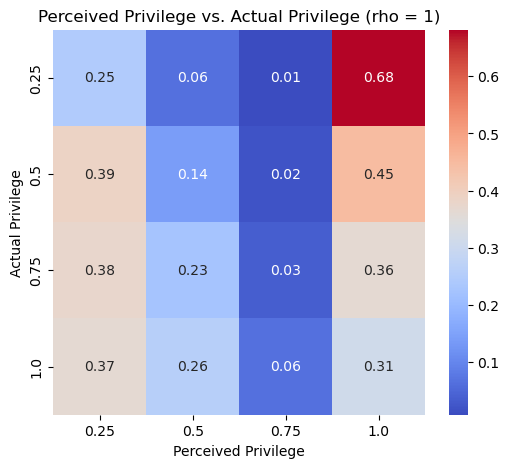

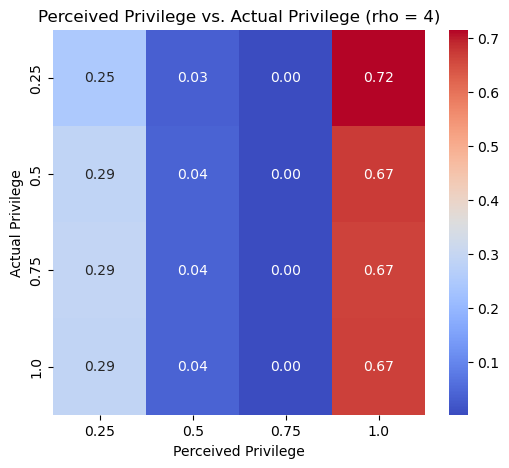

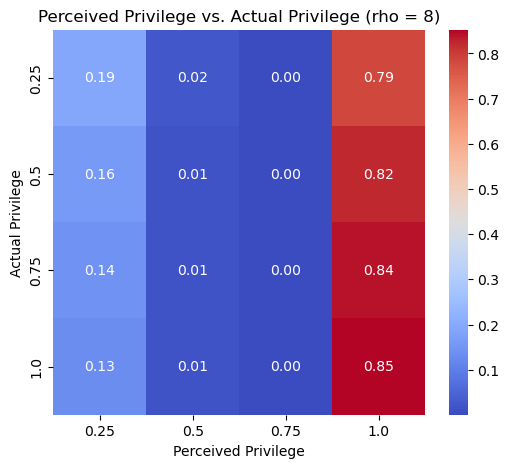

In [25]:
def infer_perceived_priv(row):
    n_higher = sum([avg > row['Y'] for avg in row['groupmeanlist']])
    return [0.25, 0.5, 0.75, 1.0][3 - n_higher]

# List of rho values
rho_values_to_plot = [0, 1, 4, 8]

for rho in rho_values_to_plot:
    # Filter the data for the current rho value and make a copy
    subset = combined_df_clean[combined_df_clean['rho_value'] == rho].copy()
    
    # Compute inferred perceived privilege for each row
    subset['perceived_priv'] = subset.apply(infer_perceived_priv, axis=1)
    
    # Compute the confusion matrix (normalized by actual privilege group)
    conf_matrix = pd.crosstab(subset['priv'], subset['perceived_priv'], normalize='index')
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title(f'Perceived Privilege vs. Actual Privilege (rho = {rho})')
    plt.xlabel('Perceived Privilege')
    plt.ylabel('Actual Privilege')
    plt.show()

### Link Neighbor Diversity - Koopmans and Schaeffer (2013)

In [26]:
def generalized_entropy(agent, agents_dict, alpha):
    own_group = agent['priv']
    neighbor_groups = [agents_dict[n]['priv'] for n in agent['linkneighbours']]
    
    if not neighbor_groups:
        return 0  # no neighbors, entropy is 0

    # Count group proportions
    total = len(neighbor_groups)
    counts = {}
    for g in neighbor_groups:
        if g != own_group:  # focusing on OUT-group diversity
            counts[g] = counts.get(g, 0) + 1

    if not counts:
        return 0  # all neighbors are in-group

    proportions = [v / total for v in counts.values()]
    
    # Generalized entropy
    entropy = sum(p ** alpha for p in proportions)
    return entropy ** (1 / (1 - alpha))

In [27]:
# Create a dictionary of agents from combined_df_clean (using the DataFrame index as the key)
agents_dict = combined_df.to_dict('index')
alpha = 2  # emphasizes evenness of distribution (0 focues on variety)

# Compute entropy for each agent and add it as a new column
combined_df['entropy'] = combined_df.apply(lambda row: generalized_entropy(row, agents_dict, alpha), axis=1)

combined_df['perceived_priv'] = combined_df_clean.apply(infer_perceived_priv, axis=1)

In [28]:
# rho_values_to_plot = [0, 1, 4, 8]
# # Generate separate boxplots for each rho value
# for rho in rho_values_to_plot:
#     df_rho = combined_df[combined_df['rho_value'] == rho]
#     plt.figure(figsize=(12, 8))
#     sns.boxplot(data=df_rho, x='priv', y='entropy', palette='Set2')
#     plt.title(f'Generalized Entropy by Actual Privilege Group for rho_value: {rho}')
#     plt.xlabel('Actual Privilege Group')
#     plt.ylabel('Entropy Score')
#     plt.grid(True)
#     plt.show()

In [29]:
# # Generate separate violinplots for each rho value
# for rho in rho_values_to_plot:
#     df_rho = combined_df[combined_df['rho_value'] == rho]
#     plt.figure(figsize=(10, 6))
#     sns.violinplot(data=df_rho, x='priv', y='entropy', palette='Set1', alpha=0.7)
#     plt.title(f'Scatterplot of Privilege vs. Entropy for rho_value: {rho}')
#     plt.xlabel('Actual Privilege Group')
#     plt.ylabel('Entropy Score')
#     plt.grid(True)
#     plt.show()

entropy vs perceived privilege

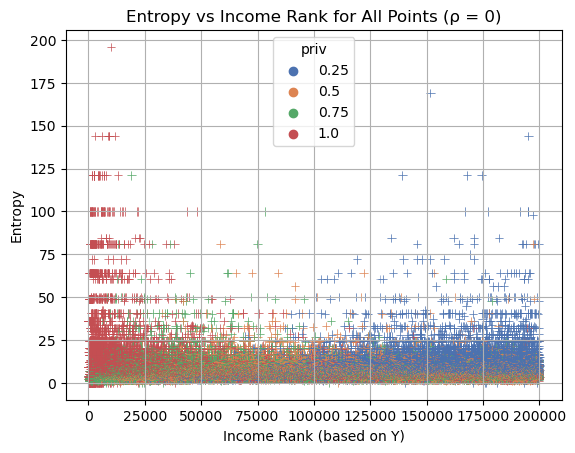

In [30]:
# Scatterplot of entropy vs. income rank for all points for ρ = 0

# Filter for ρ = 0 and ensure groupmeanlist is not null
df_rho0 = combined_df[combined_df['rho_value'] == 4].copy()
df_rho0 = df_rho0[~df_rho0['groupmeanlist'].isnull()]

# Compute income rank per row (descending order based on Y)
df_rho0['income_rank'] = df_rho0['Y'].rank(method='first', ascending=False).astype(int)

# Create the scatterplot using the '+' marker and similar styling as before
sns.scatterplot(
    data=df_rho0,
    x='income_rank',
    y='entropy',
    hue='priv',
    palette='deep',
    marker="+",
    alpha=0.7
)
plt.title('Entropy vs Income Rank for All Points (ρ = 0)')
plt.xlabel('Income Rank (based on Y)')
plt.ylabel('Entropy')
plt.grid(True)
plt.show()

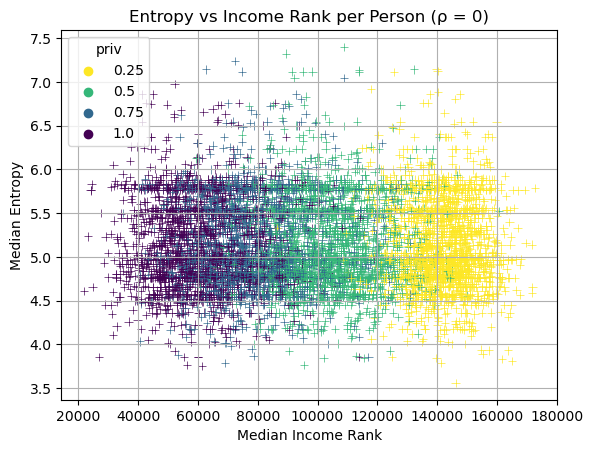

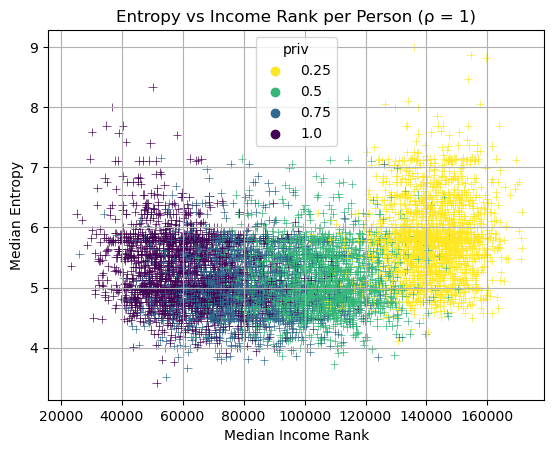

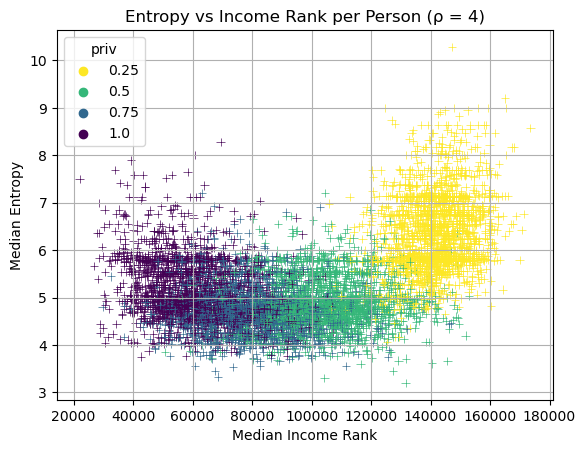

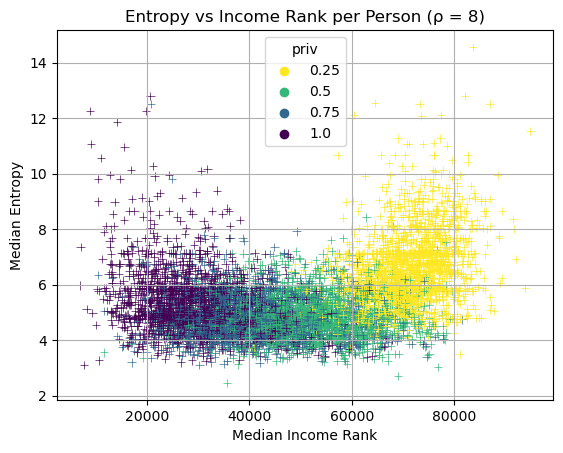

In [32]:
for rho in rho_values_to_plot:
    # Filter data for a given rho and ensure groupmeanlist is not null
    df_rho = combined_df[combined_df['rho_value'] == rho].copy()

    # Compute income rank per row (descending order based on Y)
    df_rho['income_rank'] = df_rho['Y'].rank(method='first', ascending=False).astype(int)

    # (Assuming 'entropy' has already been computed in combined_df)
    # Group by global_person_id and priv to get one point per person
    pooled_person = df_rho.groupby(['global_person_id', 'priv'], as_index=False).agg({
        'income_rank': 'median',
        'entropy': 'median'
    })

    # Create the scatterplot:
    sns.scatterplot(data=pooled_person, x='income_rank', y='entropy', hue='priv', palette='viridis_r', marker="+",)
    plt.title(f'Entropy vs Income Rank per Person (ρ = {rho})')
    plt.xlabel('Median Income Rank')
    plt.ylabel('Median Entropy')
    plt.grid(True)
    plt.show()